# Analysing data

In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import matplotlib.patches as mpatches
import numpy as np
import scipy as sc
import numbers

import xavy.explore as xe
import xavy.dataframes as xd
import xavy.plots as xp
import xavy.text as xt

## Load data

In [2]:
# Load data:
groups_df      = pd.read_csv('../data/processed/w3c_groups_properties_2024-07-25_no-tfs.csv')
part_df        = pd.read_csv('../data/processed/w3c_groups_participants_2024-07-25.csv')
affiliation_df = pd.read_csv('../data/processed/w3c_participants_affiliations_2024-07-25.csv')
org_df         = pd.read_csv('../data/processed/w3c_organizations_2024-07-26.csv')

# Prepare data:
part_df.rename({'title':'user_name', 'href':'user_link'}, axis=1, inplace=True)
org_df.rename({'id':'org_id', 'name':'org_name', 'discr':'org_discr'}, axis=1, inplace=True)
groups_df.rename({'id': 'group_id', 'name':'group_name'}, axis=1, inplace=True)

In [3]:
# Load data about W3C members ():
#members_data_df = pd.read_csv('../data/processed/w3c_member-organizations_2025-04-15.csv')
members_data_df = pd.read_csv('../data/results/w3c_member-organizations_2025-04-15_final_country-sector.csv')

## Preparing data

### Make affiliation to W3C an atttribute

* Assign a binary `is_invited_expert` column to `affiliations_df`.
* When a user has two or more affiliations and one of these affiliations is the W3C, remove the latter from the dataset.
    * Users have at most 
* When the user is only a W3C invited expert, maintain its row with W3C invited expert affiliation

In [4]:
# Hard-coded W3C invited experts identifiers:
invited_experts_org  = 'https://api.w3.org/affiliations/36747'
invited_experts_name = 'W3C Invited Experts' 
# Create table of users who are Invited Experts:
expert_aff_df = affiliation_df.loc[affiliation_df['href'] == invited_experts_org, ['call']].copy()
assert xd.iskeyQ(expert_aff_df[['call']]) # There is only one entry per user.
expert_aff_df['is_invited_expert'] = 1
expert_aff_df.set_index('call', inplace=True)

In [5]:
# Outer join invited experts flag to affiliations:
rich_aff_df = affiliation_df.loc[affiliation_df['href'] != invited_experts_org].join(expert_aff_df, on='call', how='outer')
rich_aff_df.reset_index(drop=True, inplace=True)
# Fill missing columns (unmatched entries in outer join) with no Expert or W3C invited expert affiliation:
assert affiliation_df['title'].isnull().sum() == 0
assert affiliation_df['href'].isnull().sum() == 0
rich_aff_df['is_invited_expert'] = rich_aff_df['is_invited_expert'].fillna(0).astype(int)
rich_aff_df['title'].fillna(invited_experts_name, inplace=True)
rich_aff_df['href'].fillna(invited_experts_org, inplace=True)
# Sanity checks:
assert len(rich_aff_df) <= len(affiliation_df) # The process of removing W3C invited experts as rows for those with other filiations reduces the number of rows.
assert len(rich_aff_df.query('is_invited_expert == 1')) >= len(expert_aff_df) # There are at least the number of entries as the number of experts.
# Particular case: 
assert xd.iskeyQ(rich_aff_df[['call']]) # Users have only one affiliation (apart from a possible extra W3C invited experts).

## Joining data

In [6]:
# Keys cannot be missing:
assert org_df['call'].isnull().sum() == 0
assert rich_aff_df['href'].isnull().sum() == 0

# Join organization details to affiliations:
aff_df = rich_aff_df.join(org_df.set_index('call'), on='href', how='inner')
# Just add information, no missing or duplicated lines:
assert (aff_df['title'] == aff_df['org_name']).all()
assert (len(aff_df) == len(rich_aff_df))

# Remove unnecessary columns:
aff_df = aff_df.drop(['title', 'href'], axis=1)
# Standardize URL to join with groups participants:
aff_df['call'] = aff_df['call'].str.replace('/affiliations', '', regex=False)

In [7]:
# Keys cannot be missing (the AC has no key):
assert groups_df.loc[groups_df['group_name'] != 'Advisory Committee', 'users'].isnull().sum() == 0
assert part_df['call'].isnull().sum() == 0

# Join groups to participants:
groups_parts_df = groups_df.join(part_df.set_index('call'), on='users', how='left')
groups_parts_df.drop(['call', 'users', 'participations', 'start-date', 'end-date'], axis=1, inplace=True)

In [8]:
# Keys cannot be missing (the AC has no key):
assert groups_parts_df.loc[groups_parts_df['group_name'] != 'Advisory Committee', 'user_link'].isnull().sum() == 0
assert aff_df['call'].isnull().sum() == 0

# Prepare to join info about organizations:
assert xd.iskeyQ(members_data_df[['name']])
org_country_sector_df = members_data_df.rename({'country':'org_country', 'sector':'org_sector'}, axis=1).set_index('name')[['org_country', 'org_sector']]

# Final join:
full_df = groups_parts_df.join(aff_df.set_index('call'), on='user_link', how='left').join(org_country_sector_df, on='org_name', how='left')

## Exploration and Sanity checks

### Multiple affiliations and W3C invited experts

**Conclusions:**
* Maximum number of affiliations is 2.
* In all cases of 2 affiliations, one is W3C invited expert.

In [8]:
# Number of affiliations:
affiliation_df['call'].value_counts()

https://api.w3.org/users/7kij80bu32osog8oc4ccowkosk4kwww/affiliations    2
https://api.w3.org/users/ag01ak3urmokwowwckk4k4ogcs44cw4/affiliations    2
https://api.w3.org/users/1b7nnzq1wpxcwkcwgk8888o8gk8c40g/affiliations    2
https://api.w3.org/users/kvpk862oi6o84sck88o4cwkkoso8sks/affiliations    2
https://api.w3.org/users/ef1b74t1au8kccg8cs8kk8kkck4sogs/affiliations    2
                                                                        ..
https://api.w3.org/users/pix79zeaev4wcg0g8w0048s00g40o04/affiliations    1
https://api.w3.org/users/eufqnbenydc0gkcw8cwcwgo88s484co/affiliations    1
https://api.w3.org/users/er81y1qq45ws848o0ok800go0g8w4cw/affiliations    1
https://api.w3.org/users/g5ncb6fi3bk8os000woc0w44k4o4cwo/affiliations    1
https://api.w3.org/users/iyipmsf4fugwgww884kkco8s88c8s44/affiliations    1
Name: call, Length: 8856, dtype: int64

In [9]:
xd.print_array_series(xd.check_guarda_compartilhada(affiliation_df, 'call', 'title'))

https://api.w3.org/users/16j8r76fd6pwgo00gk4ww0wwwc4888w/affiliations: University of Oxford / W3C Invited Experts
https://api.w3.org/users/18tlqziacdgk08kg0g4404s0ooo40ss/affiliations: University of Michigan / W3C Invited Experts
https://api.w3.org/users/1b7nnzq1wpxcwkcwgk8888o8gk8c40g/affiliations: JPMorgan Chase & Co. / W3C Invited Experts
https://api.w3.org/users/1ce303mlmehw4kgkg0ow4kgsooc8woo/affiliations: Away Team Software Ltd / W3C Invited Experts
https://api.w3.org/users/1j3s1yktqopws08g0kw0kk0s40ogo4c/affiliations: Prime Access Consulting, Inc. / W3C Invited Experts
https://api.w3.org/users/2iyqt9ssibi8o40wc4g440ogwkgc8s4/affiliations: Spotify Ltd / W3C Invited Experts
https://api.w3.org/users/2o9zjpjlfgmcos0cocksc0wggsg00ww/affiliations: University of Surrey / W3C Invited Experts
https://api.w3.org/users/2oshicfoos004c0k8oog48k8os0cgk4/affiliations: DataCove e.U. / W3C Invited Experts
https://api.w3.org/users/2v8fnfm6zmyogc00k4sokkcwwww8gk8/affiliations: Dublin Core Metadata

### Missing values

In [8]:
# Here are the missing values:
xe.checkMissing(full_df)

Colunas com valores faltantes:
                   coluna       N      %
4          spec-publisher  3389.0  17.29
8               user_name     1.0   0.01
9               user_link     1.0   0.01
10      is_invited_expert  5187.0  26.46
11                 org_id  5187.0  26.46
12               org_name  5187.0  26.46
13              org_discr  5187.0  26.46
14              is-member  5815.0  29.66
15  is-member-association  5815.0  29.66


**Explanation**

* Missing `user_name` and `user_link` reflects the fact that the AC group has no users associated to it.
* Missing `org_id`, `org_name`, `org_discr` and `is_invited_expert` only occurs at Community and Business Groups
    * Exceptions are: TAG, AC and Internationalization Interest Groups.
* Missing `is-member` and `is-member-association`, when organization info is present, is associated to W3C and W3C invited experts.

#### 1.

In [9]:
# Missing user info only happens at the AC:
assert (full_df.loc[full_df['user_name'].isnull(), 'group_id'] == 33280).all()

#### 2.

In [10]:
# Missing values in the columns below come all together:
org_miss_cols = ['is_invited_expert', 'org_id', 'org_name', 'org_discr']
assert set(full_df[org_miss_cols].isnull().astype(int).sum(axis=1)) == {0, len(org_miss_cols)}

# Missing organization information is associated to Community and Business Groups:
exception_group_ids = [33280, 72665, 34270] # TAG, AC and Internationalization Interest Group;
full_df.loc[full_df['org_id'].isnull() & ~full_df['group_id'].isin(exception_group_ids), 'type'].value_counts()

community group    5116
business group       42
Name: type, dtype: int64

#### 3.

In [11]:
# Missing values in the columns below come all together:
member_miss_cols = ['is-member', 'is-member-association']
assert set(full_df[member_miss_cols].isnull().astype(int).sum(axis=1)) == {0, len(member_miss_cols)}

# Missing info for present orgs is W3C and invited experts:
full_df.loc[full_df['is-member'].isnull() & ~full_df['org_id'].isnull(), 'org_name'].value_counts()

W3C Invited Experts    342
W3C                    286
Name: org_name, dtype: int64

### Primary key of the dataset

In [12]:
# List of groups and organizations have no duplicates:
assert xd.iskeyQ(groups_df[['group_id']])
assert xd.iskeyQ(org_df[['org_id']])

# There is only one group-user association (there could be more if people were affiliated to more organizations):
assert xd.iskeyQ(full_df[['group_id', 'user_link']])

In [13]:
# Each user is only associated to one organization (at most):
assert full_df[['user_link', 'org_id']].drop_duplicates()['user_link'].value_counts().max() == 1

### Only member organizations participate in WGs, IGs and Permanent Groups

**Notes**

* Only W3C and invited experts have no member information.
* Only W3C members can participate in Working, Interest and Permanent groups 
  (Exception is the Internationalization IG, which is open; and TAG, for some reason). 
  There is no info for the AC (I think it is private).

In [14]:
# All organizations have an org_id:
assert len(org_df.loc[org_df['org_id'].isnull()]) == 0

In [15]:
# Only W3C has no is member info:
print(xe.bold('How many organizations are W3C members (I guess this only counts those with representatives in some group):'))
print(org_df['is-member'].value_counts(dropna=False))
print(xe.bold('Organization with missing is_member:'))
org_df.loc[org_df['is-member'].isnull()]

How many organizations are W3C members (I guess this only counts those with representatives in some group):
False    3717
True      302
NaN         2
Name: is-member, dtype: int64
Organization with missing is_member:


org_id             org_name    org_discr is-member  \
1175   52794                  W3C  affiliation       NaN   
2544   36747  W3C Invited Experts  affiliation       NaN   

     is-member-association                                   call  
1175                   NaN  https://api.w3.org/affiliations/52794  
2544                   NaN  https://api.w3.org/affiliations/36747

In [16]:
# Select groups that supposedly only W3C members cam participate:
w3c_groups_df = full_df.loc[full_df['type'].isin(['working group', 'permanent group', 'interest group'])]
# Select participants to these groups with no affiliation:
w3c_groups_no_org_df = w3c_groups_df.loc[w3c_groups_df['org_id'].isnull()]

In [17]:
w3c_groups_no_org_df[['group_id', 'group_name']].drop_duplicates()

group_id                           group_name
11      33280                   Advisory Committee
74      72665  Internationalization Interest Group
151     34270         Technical Architecture Group

In [18]:
w3c_groups_not_members_df = w3c_groups_df.loc[w3c_groups_df['is-member'] == False]
w3c_groups_not_members_experts_df = w3c_groups_not_members_df.loc[w3c_groups_not_members_df['is_invited_expert'] == 0]
w3c_groups_not_members_experts_df[['group_id', 'group_name']].drop_duplicates()

group_id                           group_name
74      72665  Internationalization Interest Group
151     34270         Technical Architecture Group

In [19]:
# Not members, not experts, but on groups:
xd.print_string_series(w3c_groups_not_members_experts_df.set_index('user_name')['user_link'])

Eiso Chan: https://api.w3.org/users/4gmy7sq9cio0ok0gk48gck0w4ksoo0s
Somnath Chandra: https://api.w3.org/users/46n3snhjyhq8c0soswssgock0k8cc0c
Marc Durdin: https://api.w3.org/users/34oo0d80wxyc4g84cggg0okkcs0gk40
Abhijit Dutta: https://api.w3.org/users/g5h4xgpbu9s0s48kc4g4ccs0040wggs
Neha Gupta: https://api.w3.org/users/qlt9k2okay8s0ww8800wcsw0cw8ggcc
Martin Hosken: https://api.w3.org/users/761eze8dk7swc4400scw4cw8kc8ggc4
qitu hu: https://api.w3.org/users/srhj6w66zpcwgs8o8gswk84ck0wcgsc
Masaya Kobatake: https://api.w3.org/users/k4km8ub5x34wwk480c0k4s800ko4k8o
Mahesh Kulkarni: https://api.w3.org/users/b94ezv535jsc4s4g8s8c0ogcsws8c0o
Swaran Lata: https://api.w3.org/users/c95f6ecvg9w00wcc0ws4kkwsgk00oc4
Hai Liang: https://api.w3.org/users/8njxhrmcdncw8ogkokwskg40w08kwsg
Daniel Mekonnen: https://api.w3.org/users/a8jjxn8sz8wssogkwkg80sw088cswgg
Titus Nemeth: https://api.w3.org/users/2d3a1nx71wn4sogokcc8kkgsowk4g00
Yutaro Oguma: https://api.w3.org/users/gckr6rbe2q88oc808oco8kkcg80oo0c
Anshuma

In [20]:
# Not members, not experts, but on permanent groups (TAG):
xd.print_string_series(w3c_groups_not_members_experts_df.query('type == "permanent group"').set_index('user_name')['user_link'])

Tristan Nitot: https://api.w3.org/users/8gbu9gqf49c8gcgo88g0kocccsos844


In [21]:
full_df.loc[(full_df['is-member'] == True) | full_df['is-member'].isnull(), ['org_id', 'org_name', 'org_discr', 'is-member', 'is-member-association']].dropna(how='all').drop_duplicates()

org_id             org_name     org_discr is-member  \
0     98318.0       Fondazione LIA  organization      True   
0     36747.0  W3C Invited Experts   affiliation       NaN   
0     74902.0        HM Government  organization      True   
0    132463.0         Snake Nation  organization      True   
0    138132.0            UsableNet  organization      True   
..        ...                  ...           ...       ...   
184  131151.0              Dingdao  organization      True   
185  126627.0              Discord  organization      True   
188   76925.0  Ethereum Foundation  organization      True   
188  101246.0     Dfinity Stiftung  organization      True   
188  156311.0      Warm Automation  organization      True   

    is-member-association  
0                   False  
0                     NaN  
0                   False  
0                   False  
0                   False  
..                    ...  
184                 False  
185                 False  
188                 False  
188                 False  
188                 False  

[304 rows x 5 columns]

## Analysis of member organizations

**Conclusions**
* About 20% of the W3C members do not have any representative in any group.
* We found no statistically significant differences in absence between countries.
* USA is by far the most frequent HQ for W3C members.
* We found statistically significant differences between sectors: large enterprises are less absent and small/medium companies are more absent.
* Large companies are the most common type of member, followed by nonprofits and small companies.

### Functions

In [9]:
import scipy.stats.distributions as st

In [20]:
def bayes_conf_interval(n_trials, n_success, pcs=[0.05, 0.5, 0.95], dp=0.001):
    """
    Given a binomial experiment with `n_trials` (int) and 
    `n_success` (int), compute the values of the chance of 
    sucess in one trial associated to the posterior 
    accumulated values given in `pcs` (list-like).

    Return an array.
    """
    
    # Compute Likelihood:
    p = np.arange(0, 1, dp) 
    P = st.binom.pmf(n_success, n_trials, p)
    
    # Compute cumulative likelihood:
    N = np.sum(P)
    C = np.cumsum(P) / N
    
    # Get confidence intervals for specified levels:
    p_lims = np.interp(pcs, C, p)

    return p_lims

def augment_posterior_conf_intervals(df, pcs=[0.05, 0.5, 0.95]):
    """
    Given a DataFrame `df` wth int columns 'all' and 'absent',
    compute in place the median posterior probability of 
    absence and its limits.
    """
    
    # Loop over instances:
    for i in df.index:
        
        # Get instance x:
        x = df.loc[i]

        # Compute limits to absence probability:
        lims = bayes_conf_interval(x['all'], x['absent'], pcs)
        df.loc[i, 'absent_p_min'] = lims[0]
        df.loc[i, 'absent_p_med'] = lims[1]
        df.loc[i, 'absent_p_max'] = lims[2]

### Participating and non-participating members

In [11]:
# Compare 
participating_members = set(full_df.loc[full_df['is-member'] == True, 'org_name'])
members = set(members_data_df['name'])
# All `is-member == True` organizations with representatives are W3C members 
assert participating_members - members == set()

**Conclusion:** There are member organizations that do not participate in any W3C group. Below we show this fraction.

In [12]:
# Fraction of members not participating in any group at the time of data collection:
print('Fraction not participating:', len(members - participating_members) / len(members))
p_min, p_med, p_max = bayes_conf_interval(len(members), len(members - participating_members))
p_med

Fraction not participating: 0.2073490813648294


0.2078701802872298

In [13]:
# Select data about participating members only:
part_member_df = members_data_df.loc[members_data_df['name'].isin(participating_members)]

In [105]:
# Create table of representatives of member organizations:
member_reps_df = full_df.loc[full_df['is-member'] == True].drop_duplicates(subset='user_link')

### Analysis by country

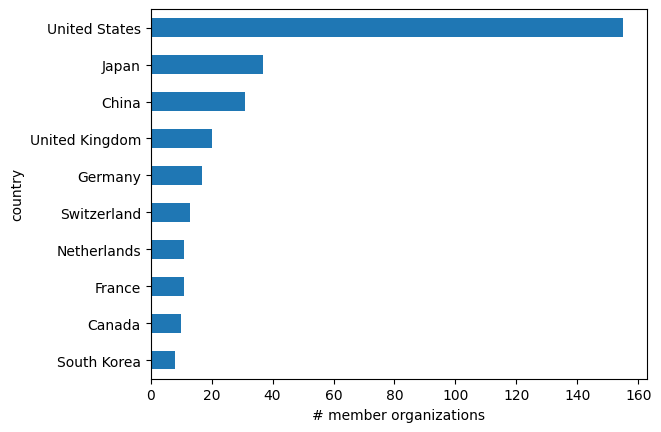

In [14]:
# Number of organizations per country:
member_by_country = members_data_df['country'].value_counts(ascending=True)
member_by_country.iloc[-10:].plot(kind='barh')
pl.xlabel('# member organizations')
pl.show()

In [32]:
# Count participating members by country:
part_member_by_country = part_member_df['country'].value_counts(ascending=True)
# Create counts df:
member_by_country_df = pd.DataFrame()
member_by_country_df['all'] = member_by_country
member_by_country_df['participating'] = part_member_by_country
member_by_country_df['participating'] = member_by_country_df['participating'].fillna(0).astype(int)
member_by_country_df['absent'] = member_by_country_df['all'] - member_by_country_df['participating']
# Add absence probability:
augment_posterior_conf_intervals(member_by_country_df, [0.01, 0.5, 0.99])

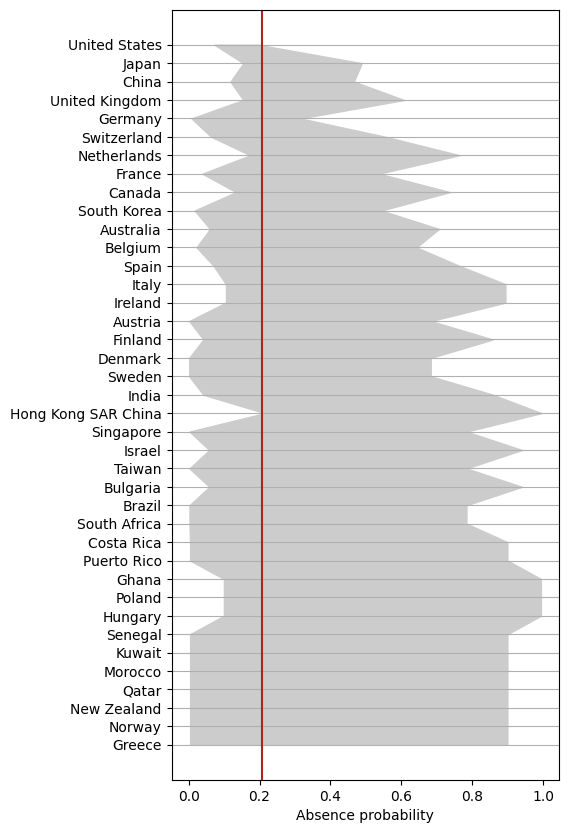

In [33]:
# Compare absence probabilities:
pl.figure(figsize=(5,10))
pl.fill_betweenx(member_by_country_df.index, member_by_country_df['absent_p_min'], member_by_country_df['absent_p_max'], color='0.8')
#pl.plot(member_by_country_df['absent_p_med'], member_by_country_df.index, color='k', linewidth=1)
pl.grid(axis='y')
pl.axvline(p_med, color='firebrick')
pl.xlabel('Absence probability')
pl.show()

#### Distribution of rep. counts by country

United States:  16.50735294117647     KstestResult(statistic=0.12854358610914246, pvalue=0.1513656205767727, statistic_location=5, statistic_sign=1)
China:  11.956521739130435     KstestResult(statistic=0.15976951283394447, pvalue=0.6188106704164056, statistic_location=12, statistic_sign=1)
Japan:  6.230769230769231     KstestResult(statistic=0.2284522706209453, pvalue=0.16145187803073024, statistic_location=4, statistic_sign=1)
Germany:  8.1875     KstestResult(statistic=0.19201807228915663, pvalue=0.5866000940705883, statistic_location=14, statistic_sign=1)
United Kingdom:  7.153846153846154     KstestResult(statistic=0.1515291936978684, pvalue=0.9031530283276582, statistic_location=4, statistic_sign=1)
Spain:  19.25     KstestResult(statistic=0.49698795180722893, pvalue=0.20309753919638213, statistic_location=7, statistic_sign=1)
France:  7.333333333333333     KstestResult(statistic=0.12248995983935743, pvalue=0.996940437044436, statistic_location=8, statistic_sign=1)
Canada:  10.66

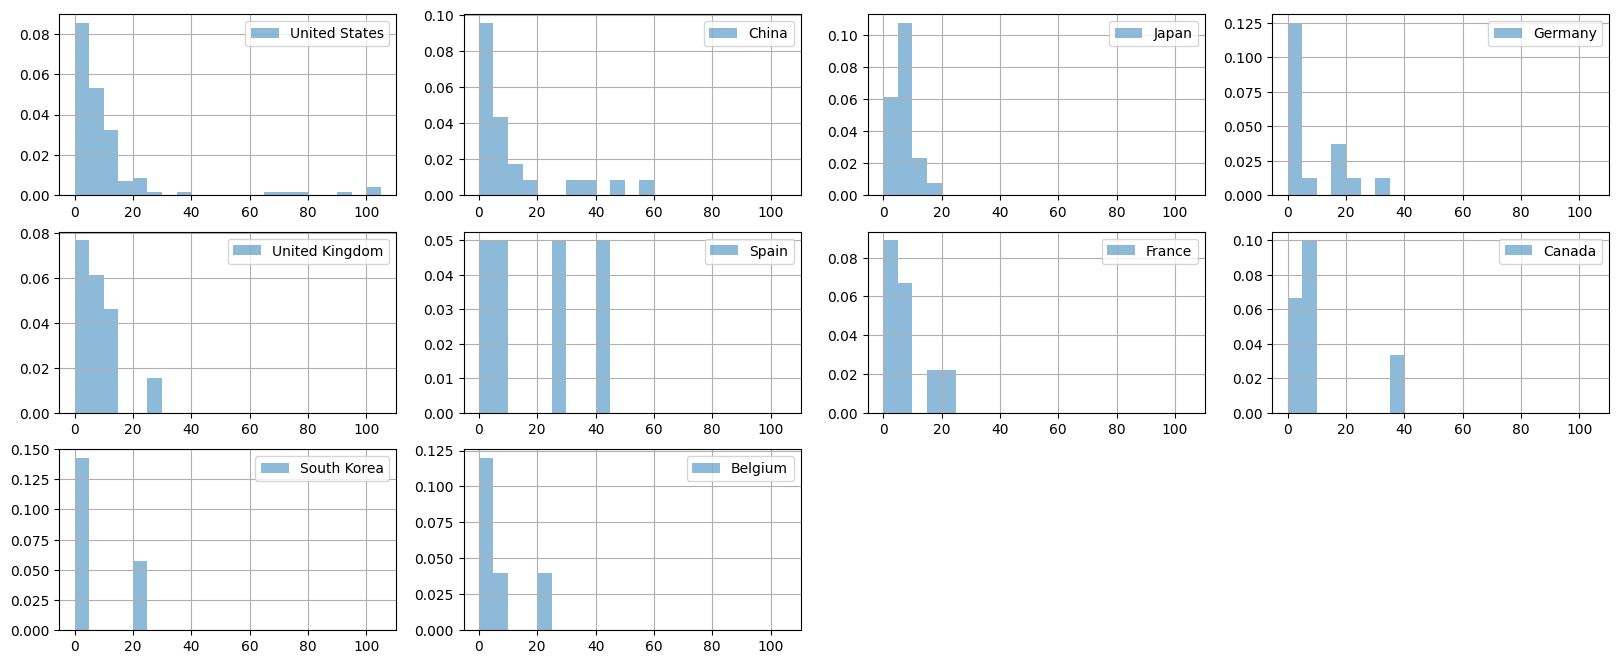

In [106]:
reps_counts = member_reps_df.loc[member_reps_df['org_country'] != 'United States']['org_name'].value_counts()

c = 'org_country'
s_list = member_reps_df[c].value_counts().index[:10]
edges = np.arange(0, 110, 5)
pl.figure(figsize=(20, 8))
for i, s in enumerate(s_list):
    pl.subplot(3, 4, i + 1)
    segment = member_reps_df.loc[member_reps_df[c] == s, 'org_name'].value_counts()
    segment.clip(upper=100).hist(bins=edges, label=s, density=True, alpha=0.5)
    print(xd.bold(s + ': '), np.mean(segment), '   ', sc.stats.kstest(reps_counts, segment))
    pl.legend()
pl.show()

### Analysis by sector

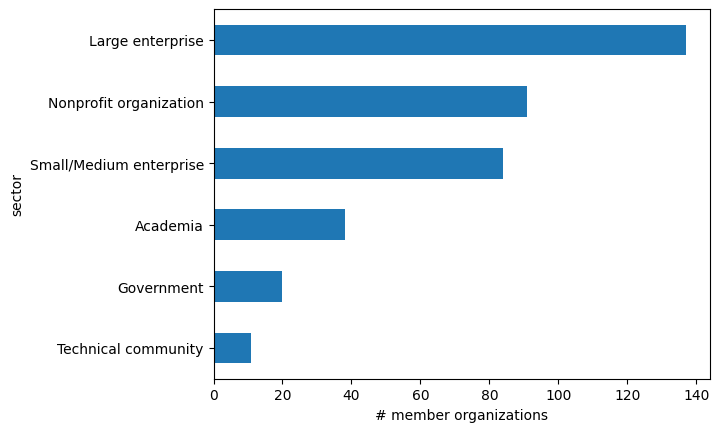

In [17]:
# Number of organizations per country:
member_by_sector = members_data_df['sector'].value_counts(ascending=True)
member_by_sector.iloc[-10:].plot(kind='barh')
pl.xlabel('# member organizations')
pl.show()

In [34]:
# Count participating members by sector:
part_member_by_sector = part_member_df['sector'].value_counts(ascending=True)
# Create counts df:
member_by_sector_df = pd.DataFrame()
member_by_sector_df['all'] = member_by_sector
member_by_sector_df['participating'] = part_member_by_sector
member_by_sector_df['participating'] = member_by_sector_df['participating'].fillna(0).astype(int)
member_by_sector_df['absent'] = member_by_sector_df['all'] - member_by_sector_df['participating']
# Add absence probability:
augment_posterior_conf_intervals(member_by_sector_df, [0.005, 0.5, 0.995])

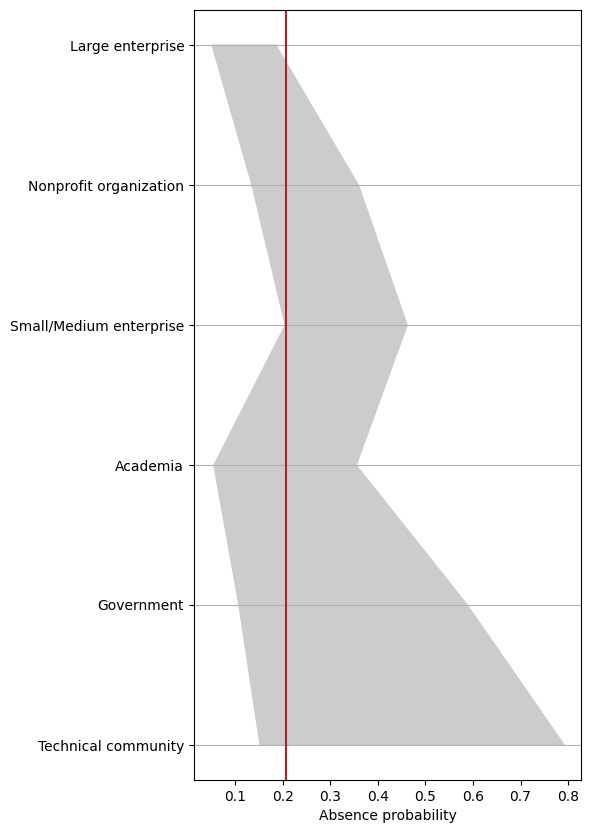

In [35]:
# Compare absence probabilities:
pl.figure(figsize=(5,10))
pl.fill_betweenx(member_by_sector_df.index, member_by_sector_df['absent_p_min'], member_by_sector_df['absent_p_max'], color='0.8')
#pl.plot(member_by_sector_df['absent_p_med'], member_by_sector_df.index, color='k', linewidth=1)
pl.grid(axis='y')
pl.axvline(p_med, color='firebrick')
pl.xlabel('Absence probability')
pl.show()

#### Distribution of rep. counts by sector

Nonprofit organization:  6.6     KstestResult(statistic=0.12894985808893095, pvalue=0.2732131602700914, statistic_location=3, statistic_sign=-1)
Government:  6.642857142857143     KstestResult(statistic=0.15562913907284767, pvalue=0.8525816322344001, statistic_location=1, statistic_sign=1)
Small/Medium enterprise:  3.824561403508772     KstestResult(statistic=0.23910770303241546, pvalue=0.0067008695606209, statistic_location=6, statistic_sign=-1)
Large enterprise:  19.276422764227643     KstestResult(statistic=0.17813492704463468, pvalue=0.006602030031250009, statistic_location=3, statistic_sign=1)
Academia:  6.53125     KstestResult(statistic=0.07181291390728477, pvalue=0.9953942908890763, statistic_location=12, statistic_sign=-1)
Technical community:  10.333333333333334     KstestResult(statistic=0.17770419426048564, pvalue=0.9743583970430763, statistic_location=1, statistic_sign=-1)


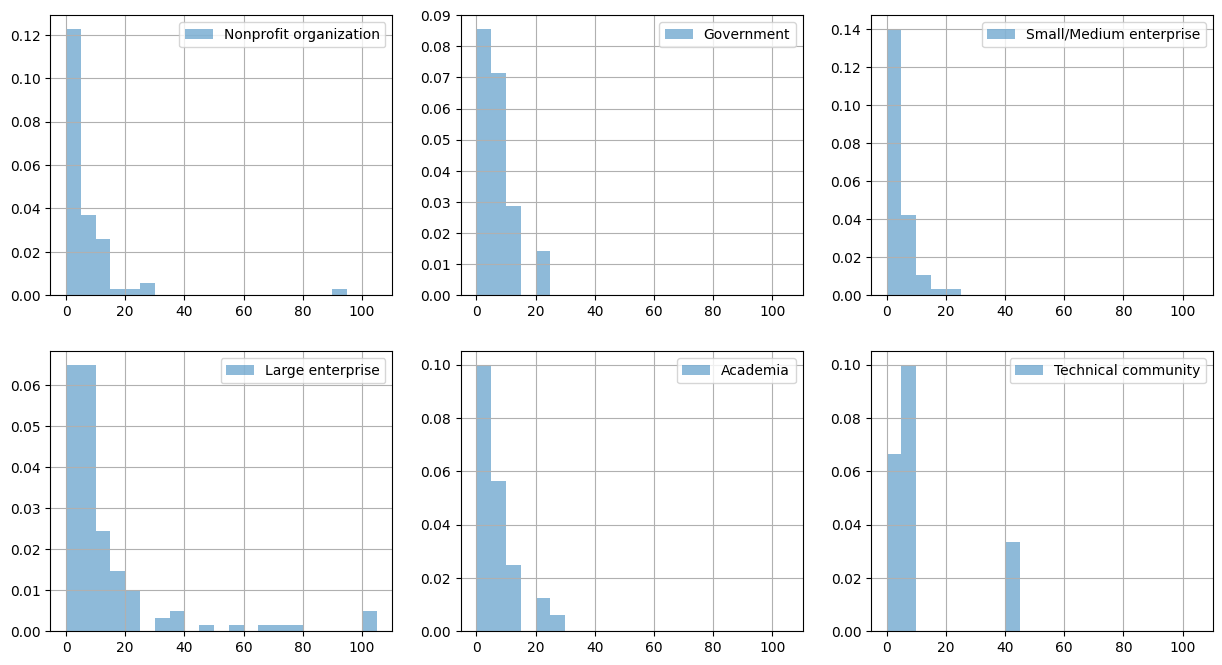

In [93]:
reps_counts = member_reps_df['org_name'].value_counts()

c = 'org_sector'
s_list = member_reps_df[c].unique()
edges = np.arange(0, 110, 5)
pl.figure(figsize=(15, 8))
for i, s in enumerate(s_list):
    pl.subplot(2, 3, i + 1)
    segment = member_reps_df.loc[member_reps_df[c] == s, 'org_name'].value_counts()
    segment.clip(upper=100).hist(bins=edges, label=s, density=True, alpha=0.5)
    print(xd.bold(s + ': '), np.mean(segment), '   ', sc.stats.kstest(reps_counts, segment))
    pl.legend()
pl.show()

## Analysis of all groups

### Group sizes

In [80]:
# Prerequisites:
assert xe.one2oneQ(full_df, 'group_id', 'group_name')
assert xd.iskeyQ(full_df[['group_id', 'user_link']])

In [81]:
# Count the number of participants in each group:
group_sizes_df = full_df[['group_name', 'type']].value_counts().reset_index().rename({0:'n_participants'}, axis=1).rename({'count':'n_participants'}, axis=1)
# No correct info for the AC:
group_sizes_df = group_sizes_df.loc[group_sizes_df['group_name'] != 'Advisory Committee']

In [82]:
# Stats:
group_sizes_df.groupby('type').describe()

n_participants                                              \
                         count        mean         std   min    25%    50%   
type                                                                         
business group             2.0  234.000000  239.002092  65.0  149.5  234.0   
community group          141.0  111.673759  191.863847   1.0   30.0   54.0   
interest group             9.0   76.777778   45.882398   3.0   45.0   79.0   
permanent group            3.0   14.333333    1.527525  13.0   13.5   14.0   
working group             43.0   61.720930   47.201859   9.0   25.5   45.0   

                                
                   75%     max  
type                            
business group   318.5   403.0  
community group  113.0  1704.0  
interest group   115.0   136.0  
permanent group   15.0    16.0  
working group     91.0   230.0

Distribution of groups per number of participants:

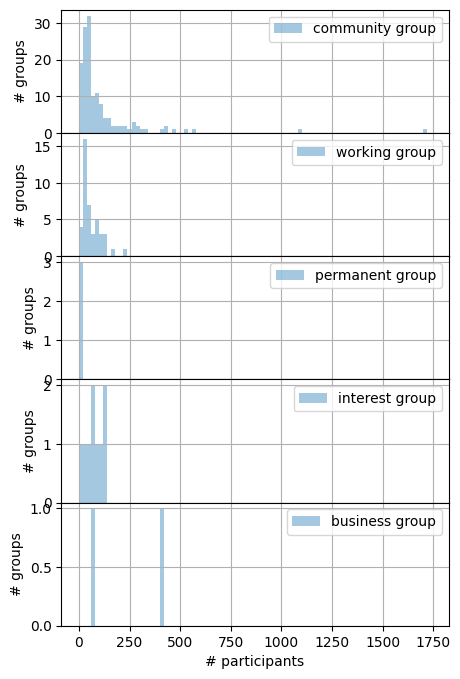

In [83]:
# Histogram:
group_types = full_df['type'].unique()
pl.figure(figsize=(5, 8))
edges = np.arange(0,1750, 20)
for i, gt in enumerate(group_types):
    pl.subplot(len(group_types), 1, i + 1)
    group_sizes_df.loc[group_sizes_df['type'] == gt, 'n_participants'].hist(bins=edges, label=gt, alpha=0.4)
    pl.legend()
    pl.ylabel('# groups')

pl.xlabel('# participants')    
pl.subplots_adjust(hspace=0)
pl.show()

We test below if their distributions are statistically the same:

In [84]:
sc.stats.kstest(group_sizes_df.query('type == "community group"')['n_participants'], group_sizes_df.query('type == "working group"')['n_participants'])

KstestResult(statistic=0.15916213095827147, pvalue=0.3316671838882836, statistic_location=133, statistic_sign=-1)

In [85]:
sc.stats.kstest(group_sizes_df.query('type == "interest group"')['n_participants'], group_sizes_df.query('type == "working group"')['n_participants'])

KstestResult(statistic=0.34108527131782945, pvalue=0.2803485707305701, statistic_location=73, statistic_sign=-1)

In [86]:
sc.stats.kstest(group_sizes_df.query('type == "community group"')['n_participants'], group_sizes_df.query('type == "interest group"')['n_participants'])

KstestResult(statistic=0.2765957446808511, pvalue=0.45872259416348765, statistic_location=74, statistic_sign=1)

A large p-value indicate the hypothesis they are drawn from the same distribution is valid. 

### Organizations with the largest amount of representatives

In [36]:
def get_x_spine_position(ax):
    """
    Returns the position of the spine of x-axis in `ax` 
    ('top' or 'bottom'). 
    """
    if ax == pl:
        ax = pl.gca()
    pos = ax.xaxis.get_label_position()
    
    return pos

def mark_ref_coords(y, y0, xmin=0, ymin=0, ax=pl, fontsize=8, legend=True, **kwargs):
    """
    Mark a vertical line at the position on the x-axis where 
    the curve `y` reaches the value `y0`.
    """
    
    x0 = np.argmin((y - y0)**2)
    xmax = len(y)
    print(f'{y0}: {x0}')
    #ax.hlines(y0, xmin=xmin, xmax=x0, **kwargs)
    
    # Hard-coded:
    vpad = 2 # Absolute value
    hpad = 1 # Fractional value (%)
    
    spine = get_x_spine_position(ax)
    if spine == 'bottom':    
        ax.vlines(x0, ymin=ymin, ymax=y0, **kwargs)
        if legend == True:
            ax.text(x0 - hpad / 100 * xmax, ymin + vpad, f'{y0}% of reps.', rotation=-90, fontsize=fontsize, ha='right', color=kwargs['color'])
    elif spine == 'top':    
        ax.vlines(x0, ymin=y0, ymax=100, **kwargs)
        #if legend == True:
        #    ax.text(x0 - hpad / 100 * xmax, 100 - vpad, f'{y0}% of reps.', rotation=-90, fontsize=fontsize, ha='right', va='top', color=kwargs['color'])

def counts2cumfrac(rep_counts):
    """
    Compute the cumulative fraction of a count Series.
    """
    # Compute cumulative fraction:
    cumfrac = rep_counts.sort_values(ascending=False).cumsum()
    cumfrac = cumfrac / cumfrac.iloc[-1] * 100
    return cumfrac        

def plot_cum_reps(rep_counts, color='b', ax=pl, xlabel=None, label=None):
    """
    Given a Series of organization representative counts `rep_counts`,
    plot the cummulative fraction of representatives that belong to 
    each organization, ranked from the largest to the smallest.
    """
    
    # Compute cumulative fraction:
    cumfrac = counts2cumfrac(rep_counts)

    # Plot curve:
    ax.plot(np.arange(1, 1 + len(cumfrac)), cumfrac, color=color, label=label)

    # Set plotting limits:
    xmin = 0
    xmax = len(cumfrac) + 5    
    pl.xlim([xmin, xmax])
    pl.ylim([0, 100])

    # Add references:
    mark_ref_coords(cumfrac, 50, ax=ax, linestyle='dotted', linewidth=1, color=color)
    mark_ref_coords(cumfrac, 80, ax=ax, linestyle='--', linewidth=1, color=color)
    
    # Check if x-axis in on the bottom or top:
    spine = get_x_spine_position(ax)
    
    # Format axes:
    if spine == 'top':
        ax.spines['bottom'].set_visible(False)
    elif spine == 'bottom':
        ax.spines['top'].set_visible(False)
    ax.spines[spine].set_color(color)            # Axis line
    ax.xaxis.label.set_color(color)                 # Axis label
    ax.tick_params(axis='x', colors=color)          # Tick labels and tick marks

    pl.xlabel(xlabel)

In [37]:
# Definition of group sets:
chartered_groups = ['working group', 'interest group']
nonchartered_groups = ['business group', 'community group']
# Selecting data about group sets:
chartered_df = full_df.loc[full_df['type'].isin(chartered_groups)]
nonchartered_df = full_df.loc[full_df['type'].isin(nonchartered_groups)]

50: 525
80: 2381
50: 20
80: 109


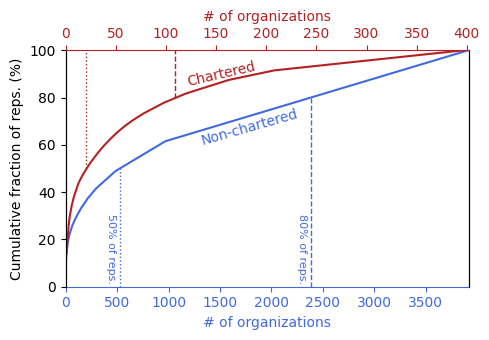

In [11]:
# 
chartered_rep_counts    = chartered_df.drop_duplicates(subset='user_link')['org_name'].value_counts()
nonchartered_rep_counts = nonchartered_df.drop_duplicates(subset='user_link')['org_name'].value_counts()

fig, ax1 = pl.subplots(figsize=(5, 3.5))
pl.ylabel('Cumulative fraction of reps. (%)')

xlabel = '# of organizations'
plot_cum_reps(nonchartered_rep_counts, 'royalblue', ax=ax1, xlabel=xlabel, label='non-chartered groups')
pl.text(1300, 60, 'Non-chartered', color='royalblue', rotation=16)

ax2 = ax1.twiny()
plot_cum_reps(chartered_rep_counts, 'firebrick', ax=ax2, xlabel=xlabel, label='chartered groups')
pl.text(120, 85, 'Chartered', color='firebrick', rotation=13)

pl.tight_layout()
#pl.savefig('../resultados/artigo/images/org-reps-cum-fracs.eps')
pl.show()

#### Check significance of higher concentration in chartered groups

In [12]:
import xavy.dataframes as xd
from xavy.economy import gini_coefficient
from sklearn.feature_extraction.text import CountVectorizer

In [26]:
# Resample rep. counts in non-chartered groups:
n_trials = 10000
n_chartered = len(chartered_rep_counts)
trials = []
orgs = []
# Loop:
for i in range(n_trials):
    # Resample:
    s = nonchartered_rep_counts.sample(n_chartered)
    # Save orgs. names:
    orgs.append(list(s.index))
    # Compute Gini coeff:
    g = gini_coefficient(s)
    trials.append(g)
# Organize gini and orgs. names:    
gini_trials = pd.Series(trials)
orgs_trials = '<' + pd.DataFrame(data=orgs) + '>'

Non-chartered 0.443
Chartered 0.685


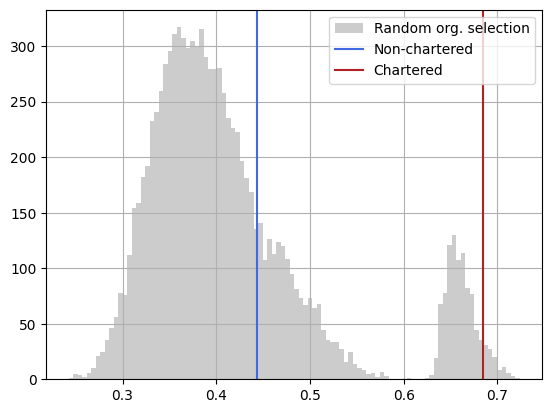

In [27]:
# Plot gini prob for resamples:
gini_trials.hist(bins=100, color='0.8', label='Random org. selection')
nonchartered_gini = gini_coefficient(nonchartered_rep_counts)
chartered_gini = gini_coefficient(chartered_rep_counts)
print('Non-chartered', '{:.3f}'.format(nonchartered_gini))
print('Chartered', '{:.3f}'.format(chartered_gini))
pl.axvline(nonchartered_gini, color='royalblue', label='Non-chartered')
pl.axvline(chartered_gini, color='firebrick', label='Chartered')
pl.legend()
pl.show()

In [28]:
# p-value of Gini index in Chartered groups:
(gini_trials > chartered_gini).mean()

0.0107

In [29]:
# Chance of falling into the second cluster in the bimodal distribution:
(gini_trials > 0.61).mean()

0.0987

The p-vlaue above shows that the gini index in chartered groups is not derived from a random sample of orgs. that participate in non-chartered groups. Thus, there must be a sociological explanation for why organizations' representatives are more concentrated in Chartered groups. 

In [30]:
# Check which organizations are present in each random realization:
org_counter = CountVectorizer(lowercase=False, token_pattern='<[^<>]+>')
corpus = xd.str_join(orgs_trials, ' ')
org_counts = org_counter.fit_transform(corpus)
onehot_org_df = pd.DataFrame(data=org_counts.toarray(), columns=org_counter.get_feature_names_out())

# Org presence matrix should be boolean:
assert ((onehot_org_df == 0) | (onehot_org_df == 1)).all().all()

In [31]:
# As expected, a random sample should include orgs. with equal probability:
onehot_org_df.mean().sort_values()

<Sphereon>                   0.0918
<Blend Media>                0.0919
<ZeuSWarE GmbH>              0.0921
<Assister Technology Ltd>    0.0921
<Art of Context>             0.0923
                              ...  
<Mastercard Incorporated>    0.1105
<Damn Good BV>               0.1106
<CBE>                        0.1109
<Unum ID>                    0.1115
<Digitaal Vlaanderen>        0.1118
Length: 3913, dtype: float64

In [32]:
# Split samples into high and low gini clusters:
high_gini_df = onehot_org_df.loc[gini_trials > 0.61]
low_gini_df  = onehot_org_df.loc[gini_trials < 0.61]

Google is required to be in the sample to make it require a sociological explanation, but it is not sufficient:

In [365]:
# Org. frequency in high Gini samples:
high_gini_df.mean().sort_values()

<Portland Community College>           0.059686
<HiveMQ>                               0.072251
<Filament Group>                       0.074346
<Voxtok>                               0.074346
<Merchant Advisory Group>              0.074346
                                         ...   
<Jesushi33>                            0.130890
<Jun Group>                            0.130890
<Federation of European Publishers>    0.130890
<Avid Technology>                      0.131937
<Google LLC>                           1.000000
Length: 3913, dtype: float64

In [366]:
# Org. frequency in low Gini samples:
low_gini_df.mean().sort_values()

<Google LLC>                              0.000000
<Inmar, Inc>                              0.091321
<Ravelin>                                 0.091653
<Owlkicks>                                0.091985
<Center for Democracy and Technology>     0.091985
                                            ...   
<Jonas Software>                          0.111332
<Universidade autonoma de tamaulipas,>    0.111443
<Cin7>                                    0.112106
<TRUSTX>                                  0.112769
<Skroot>                                  0.112991
Length: 3913, dtype: float64

#### Who are the most represented organizations

In [13]:
# Requirements:
assert xd.iskeyQ(aff_df[['call']])

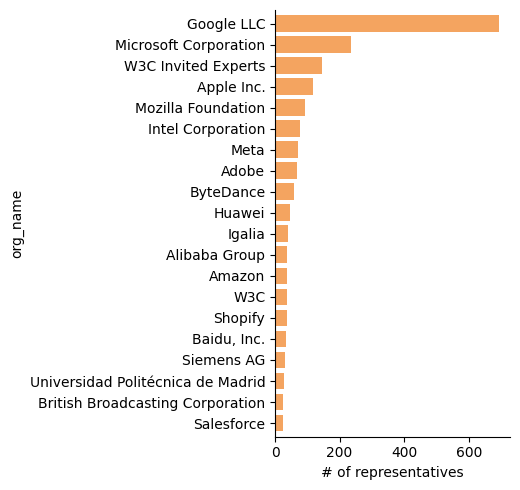

In [14]:
# Plot:
pl.figure(figsize=(5.3,5))
is_member = aff_df.drop_duplicates(subset='org_name').set_index('org_name')['is-member']
org_n_people = aff_df['org_name'].value_counts()
toplot = org_n_people.sort_values().tail(20)
colors = is_member.map(lambda x: 'blue' if x else 'red').loc[toplot.index]
toplot.plot(kind='barh', color='sandybrown', width=0.8)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.xlabel('# of representatives')
pl.tight_layout()
#pl.savefig('../resultados/artigo/images/n-reps-per-org.eps')
pl.show()

**PS:** The W3C Invited Experts only counts those without a second affiliation besides this one.

In [62]:
# Check if users in full_df can be grouped by organization to obtain the number of representatives:
test = (org_n_people.sort_index() - full_df.drop_duplicates(subset='user_link')['org_name'].value_counts().sort_index())
test.loc[test != 0]

org_name
W3C Invited Experts    1
mesur.io               1
Name: count, dtype: int64

The code above shows the non-zero differences in number of representatives each organization have depending on the methodology. It should be small and limited to a few organizations. 

### Representativeness of countries and sectors

In this analysis we will consider only W3C member organizations and will exclude W3C and W3C Invited Experts. 

In [41]:
# Selecting data:
all_orgs_df = full_df.loc[~full_df['org_id'].isnull()]
members_df = all_orgs_df.loc[all_orgs_df['is-member'].isnull() | (all_orgs_df['is-member'] == True)]
noW3C_members_df = members_df.loc[~members_df['org_name'].isin(['W3C', 'W3C Invited Experts'])]

In [42]:
xe.checkMissing(noW3C_members_df)

Colunas com valores faltantes:
           coluna       N      %
4  spec-publisher  2913.0  42.33


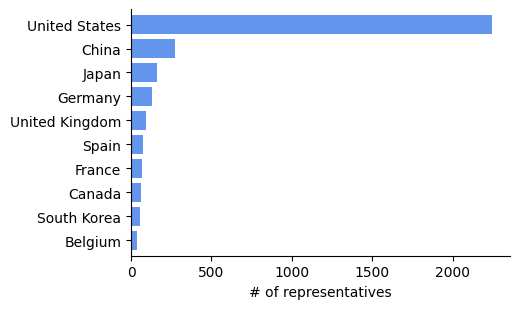

In [113]:
pl.figure(figsize=(5.3, 3.2))
toplot = noW3C_members_df.drop_duplicates(subset='user_link')['org_country'].value_counts(ascending=True).iloc[-10:]
toplot.plot(kind='barh', color='cornflowerblue', width=0.8)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.xlabel('# of representatives')
pl.ylabel('')
pl.tight_layout()
#pl.savefig('../resultados/artigo/images/n-reps-per-country.eps')
pl.show()

In [104]:
counts_by_country = noW3C_members_df.drop_duplicates(subset='user_link')['org_country'].value_counts()
counts_by_country / counts_by_country.sum()

org_country
United States     0.657394
China             0.080527
Japan             0.047438
Germany           0.038360
United Kingdom    0.027233
Spain             0.022548
France            0.019327
Canada            0.018741
South Korea       0.016105
Belgium           0.010249
Switzerland       0.009663
Netherlands       0.005857
Austria           0.004978
South Africa      0.004685
Taiwan            0.004100
Ireland           0.003807
Sweden            0.003514
Denmark           0.003514
Finland           0.003514
Singapore         0.002928
Australia         0.002635
Brazil            0.002343
Morocco           0.001464
Italy             0.001464
Israel            0.001464
Puerto Rico       0.001171
New Zealand       0.001171
Bulgaria          0.000878
Greece            0.000586
Senegal           0.000586
India             0.000586
Qatar             0.000293
Costa Rica        0.000293
Kuwait            0.000293
Norway            0.000293
Name: count, dtype: float64

In [119]:
members_data_df.loc[members_data_df['country'] == 'Russia']

Empty DataFrame
Columns: [name, country, llm_sector, my_sector, sector]
Index: []

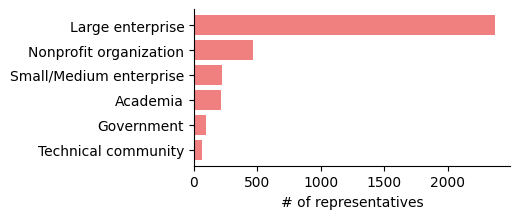

In [57]:
pl.figure(figsize=(5.3, 2.3))
toplot = noW3C_members_df.drop_duplicates(subset='user_link')['org_sector'].value_counts(ascending=True)
toplot.plot(kind='barh', color='lightcoral', width=0.8)
ax = pl.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
pl.xlabel('# of representatives')
pl.ylabel('')
pl.tight_layout()
#pl.savefig('../resultados/artigo/images/n-reps-per-sector.eps')
pl.show()

### Participation of Big Techs

#### Counting participations per group

In [15]:
def count_participants(full_df, org_name):
    """
    For each group, count the number of participants from a given organization.
    
    Parameters
    ----------
    full_df : DataFrame
        Dataset with one row per participation (person) in a group, for all
        groups.
    org_name : str
        Organization name (as in 'org_name' column).
    
    Returns
    -------
    counts : Series
        Number of participants in each group that are affiliated to the
        specified organization.
    """
    
    sel_df = full_df.loc[full_df['org_name'] == org_name]
    counts = sel_df['group_name'].value_counts()
    counts.name = xt.text2tag(org_name)
    
    return counts

In [36]:
# List of organizations:
bigtechs = ['Google LLC', 'Microsoft Corporation', 'Apple Inc.', 'Mozilla Foundation', 'Intel Corporation', 'Meta', 'Adobe', 'ByteDance', 'Huawei', 'Igalia', 'Alibaba Group', 'Amazon']
bg_cols  = [xt.text2tag(b) for b in bigtechs]

# Count participants of each organization:
bigtech_counts_df = group_sizes_df
for i in range(0, len(bigtechs)):
    bigtech_counts_df = bigtech_counts_df.join(count_participants(full_df, bigtechs[i]), on='group_name', how='left')
    bgtag = xt.text2tag(bigtechs[i])
    bigtech_counts_df[bgtag] = bigtech_counts_df[bgtag].fillna(0).astype(int)

# Estimate variation in number of participants from each organization:
dev_df = np.sqrt(bigtech_counts_df.set_index('group_name')[bg_cols])
xd.add_column_suffix(dev_df, 'dev_', prefix=True, inplace=True)

# Compute fraction of groups that are from each organization:
frac_df = bigtech_counts_df.set_index('group_name')[bg_cols].div(bigtech_counts_df.set_index('group_name')['n_participants'], axis=0)
xd.add_column_suffix(frac_df, 'frac_', prefix=True, inplace=True)

# Compute uncertainty for fraction:
frac_dev_df = dev_df.div(bigtech_counts_df.set_index('group_name')['n_participants'], axis=0)
xd.add_column_suffix(frac_dev_df, 'frac_', prefix=True, inplace=True)

# Join all data:
bigtech_stats_df = bigtech_counts_df.join(dev_df, on='group_name', how='left').join(frac_df, on='group_name', how='left').join(frac_dev_df, on='group_name', how='left')

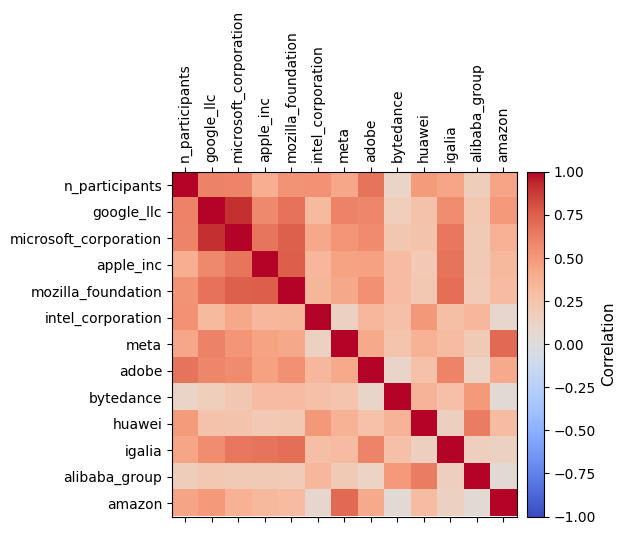

In [17]:
xp.matrix_show(bigtech_counts_df[['n_participants'] + bg_cols].corr(), 'coolwarm', 'Correlation', vmin=-1, vmax=1)

In [130]:
bigtech_counts_df[bg_cols].sum()

google_llc               1411
microsoft_corporation     403
apple_inc                 291
mozilla_foundation        157
intel_corporation         211
meta                      127
adobe                     105
bytedance                  98
huawei                     82
igalia                     89
alibaba_group              68
amazon                     64
dtype: int64

#### Relation with total number of participants

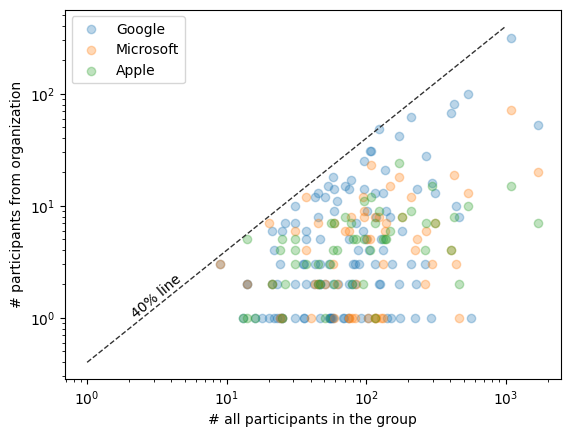

In [123]:
pl.scatter(bigtech_counts_df['n_participants'], bigtech_counts_df['google_llc'], alpha=0.3, label='Google')
pl.scatter(bigtech_counts_df['n_participants'], bigtech_counts_df['microsoft_corporation'], alpha=0.3, label='Microsoft')
pl.scatter(bigtech_counts_df['n_participants'], bigtech_counts_df['apple_inc'], alpha=0.3, label='Apple')
pl.plot([1, 1000], 0.4 * np.array([1, 1000]), color='0.2', linewidth=1, linestyle='--')
pl.text(2,1, '40% line', rotation=40)
pl.xscale('log')
pl.yscale('log')
pl.xlabel('# all participants in the group')
pl.ylabel('# participants from organization')
pl.legend()
pl.show()

<ErrorbarContainer object of 3 artists>

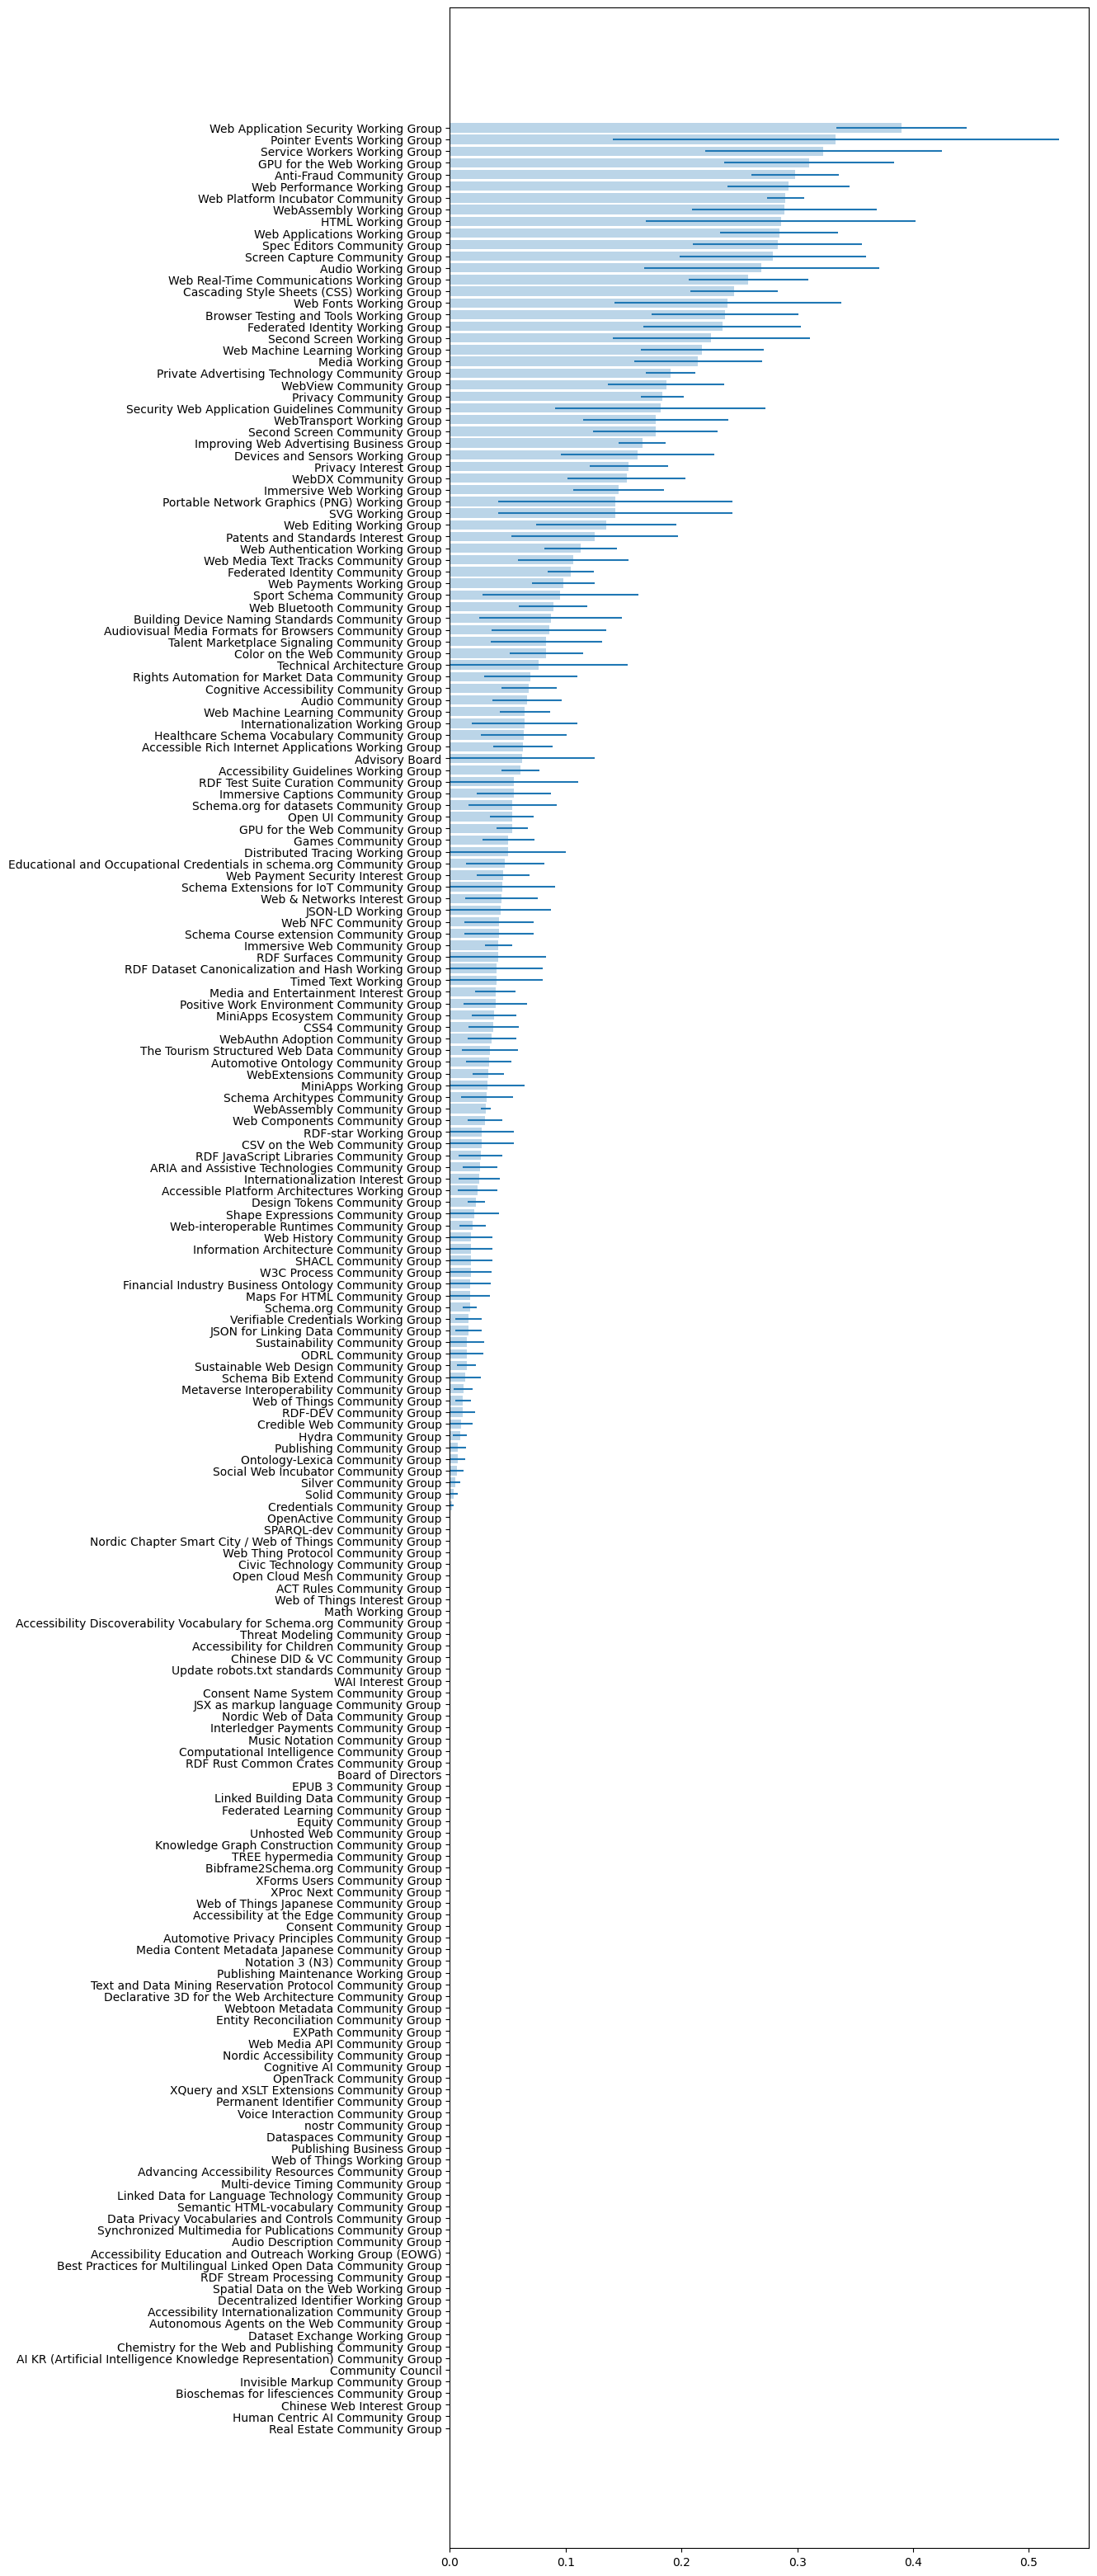

In [ ]:
toplot_df = bigtech_stats_df.sort_values('frac_google_llc')
pl.figure(figsize=(10,40))
pl.barh(toplot_df['group_name'], toplot_df['frac_google_llc'], alpha=0.3)
pl.errorbar(toplot_df['frac_google_llc'], toplot_df['group_name'], xerr=toplot_df['frac_dev_google_llc'], linestyle='none')

## Investigating non-member participation

First, participations are well distributed among members, non-members and non-of-the-above:

In [120]:
# `full_df` is participation table:
assert xd.iskeyQ(full_df[['group_id', 'user_link']])

In [121]:
# Count participation (person in a group) membership status:
full_df['is-member'].value_counts(dropna=False)

False    6907
True     6881
NaN      5815
Name: is-member, dtype: int64

Participation with no membership information are mostly people with no affiliation. The remaining are invited experts or W3C:

In [117]:
# Organizations of people with no membership info:
nomemberinfo_df = full_df.loc[full_df['is-member'].isnull()]
nomemberinfo_df['org_name'].value_counts(dropna=False)

NaN                    5187
W3C Invited Experts     342
W3C                     286
Name: org_name, dtype: int64

In [127]:
# ID organizations that are members and that are not members (W3C and invited experts are ignored):
member_orgs = set(full_df.loc[full_df['is-member'] == True, 'org_name'])
nonmember_orgs = set(full_df.loc[full_df['is-member'] == False, 'org_name'])
print('# member orgs:', len(member_orgs))
print('# non-member orgs:', len(nonmember_orgs))

# member orgs: 302
# non-member orgs: 3717


In [128]:
# Add membership into to orgs. participant counts:
org_part_df = org_n_people.reset_index().rename({'org_name':'n_people', 'index':'org_name'}, axis=1)
org_part_df.loc[org_part_df['org_name'].isin(member_orgs), 'is-member'] = 1
org_part_df.loc[org_part_df['org_name'].isin(nonmember_orgs), 'is-member'] = 0
#org_part_df['is-member'].fillna(0, inplace=True)

In [133]:
# Number of people from members and non-members:
n_part_members = org_part_df.loc[org_part_df['is-member'] == 1, 'n_people'].sum()
n_part_nonmembers = org_part_df.loc[org_part_df['is-member'] == 0, 'n_people'].sum()
print('# people from member orgs:', n_part_members)
print('# people from non-member orgs:', n_part_nonmembers)

# people from member orgs: 3416
# people from non-member orgs: 5256


In [116]:
# Most engaged non-member orgs:
org_part_df.query('`is-member` == 0').head(20)

org_name  n_people  is-member
41                                       Red Hat        15        0.0
46                              Ghent University        14        0.0
49                           Open Data Institute        14        0.0
51   Massachusetts Institute of Technology (MIT)        13        0.0
53                                     1Password        13        0.0
58                                       Taboola        12        0.0
60                                 Neustar, Inc.        12        0.0
66                        RWTH Aachen University        12        0.0
68                                      Dashlane        11        0.0
70                        Trinity College Dublin        11        0.0
76                                           TNO        11        0.0
83                          Penguin Random House        10        0.0
87                                  CJ Affiliate        10        0.0
90                           Integral Ad Science         9        0.0
93                       Coil Technologies, Inc.         9        0.0
95            University of California, Berkeley         9        0.0
99                          University of Oxford         8        0.0
104                                       GroupM         8        0.0
105                        University of Bologna         8        0.0
108                                       Yandex         8        0.0

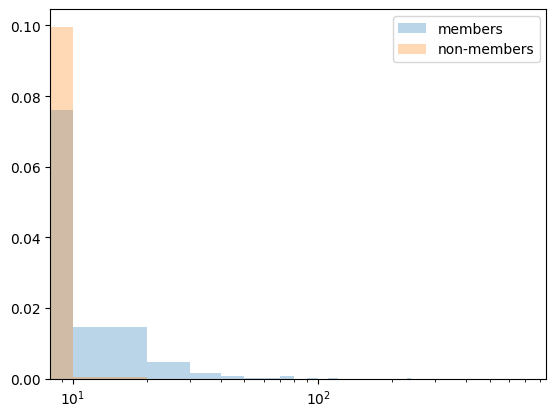

In [125]:
edges = np.arange(0,700, 10)
pl.hist(org_part_df.query('`is-member` == 1')['n_people'], bins=edges, alpha=0.3, label='members', density=True)
pl.hist(org_part_df.query('`is-member` == 0')['n_people'], bins=edges, alpha=0.3, label='non-members', density=True)
#pl.ylim([0, 500])
pl.xscale('log')
pl.legend()
pl.show()

## Analysis of invited experts

**Conclusions**
* 54% of invited experts seems truly autonomous individuals, independent from organizations.
* The remaining are well distributed among many organizations

Thus, in terms of identifying organizations with power, there is no need to look into invited experts.

In [145]:
# Selection of participations of experts:
experts_df = full_df.loc[full_df['is_invited_expert'] == 1]

A manual inspection of a few invited experts with no affiliation show they are solo entrepeneurs, freelancers, and alike:

In [151]:
xd.print_string_series(experts_df.loc[experts_df['org_name'] == 'W3C Invited Experts'].set_index('user_name')['user_link'].sample(10))

Michael Specter: https://api.w3.org/users/aroxteyu7i80wksk4g8w0ogs8sgs8ks
Pavlo Buidenkov: https://api.w3.org/users/jpsf636dgiokk80044wsowo040sswkw
David MacDonald: https://api.w3.org/users/s460v84tnsgoswskc8owwks0kwwg0gw
Travis Leithead: https://api.w3.org/users/iwn8gwnpuw8o8kcwoscgcwos0c8s8c8
Kurt Cagle: https://api.w3.org/users/9a26fdb3yqskoks88gkw4gwocscgk4o
John Foliot: https://api.w3.org/users/jdvzm62bmyo0scssk880kcs40kkc8g0
David Benoit: https://api.w3.org/users/18v63zxfoef40g0wg84sow0cg80cc4w
Laura Brady: https://api.w3.org/users/6vx7zm4hff48gckcock4scso0oskkog
Sebastian Crane: https://api.w3.org/users/mlbvhudut7kkwko0g4scg4skkwgkc44
Todd Libby: https://api.w3.org/users/p8385rml41cos040s0oc48og8ksgggc


In [153]:
# Total number of participations:
len(experts_df)

636

We see below that about 54% of the participations are by people not affiliated to any organization:

In [154]:
# Experts by organization:
experts_df['org_name'].value_counts()

W3C Invited Experts                                   342
FortuneTimes Group                                     27
University of Bialystok                                 9
Tucows                                                  8
Krellian                                                8
                                                     ... 
International Association of Privacy Professionals      1
Deloitte & Touche LLP                                   1
Internet Safety Labs                                    1
Information Commissioner's Office                       1
Royal Holloway University of London                     1
Name: org_name, Length: 132, dtype: int64

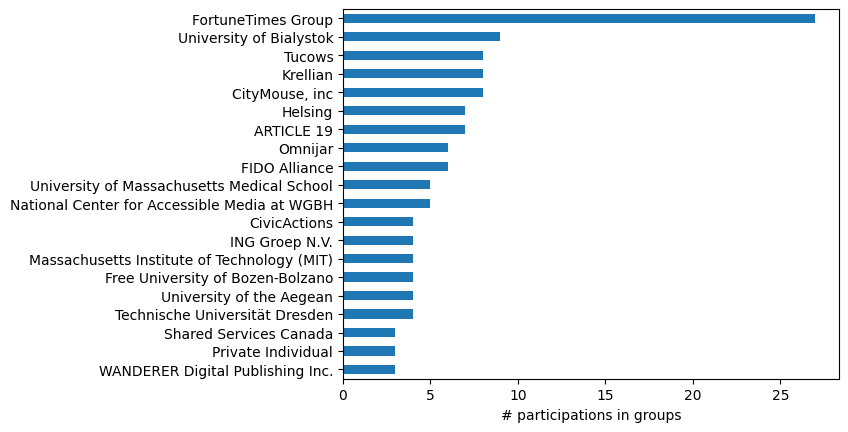

In [161]:
# Most represented organizations among invited experts (ignoring independent people):
experts_df['org_name'].value_counts().drop('W3C Invited Experts').iloc[0:20].iloc[::-1].plot(kind='barh')
pl.xlabel('# participations in groups')
pl.show()

It seems that the affiliation of invited experts is not concentrated on a few organizations:

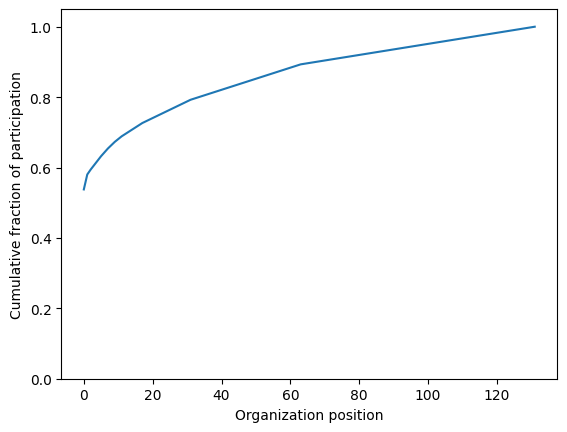

In [170]:
# Cumulative participation of invited experts on W3C groups:
cum_participations_experts = experts_df['org_name'].value_counts().cumsum()
pl.plot((cum_participations_experts / cum_participations_experts.iloc[-1]).values)
pl.ylim([0, 1.05])
pl.xlabel('Organization position')
pl.ylabel('Cumulative fraction of participation')
pl.show()

## Analisys of non-member organizations

In [179]:
# Data selection (let's ignore invited experts and permanent groups):
nonmember_df = full_df.loc[(full_df['is-member'] == False) & (full_df['is_invited_expert'] == 0) & (full_df['type'] != 'permanent group')]

In [180]:
nonmember_df['type'].value_counts()

community group    6403
business group      185
interest group       24
Name: type, dtype: int64

**PS:** participation in interest group only occurs in the Internationalization Interest Group.

In [137]:
def count_reps_per_group(participation_df):
    """
    Given a table where each row is one participation of a person 
    in a group, return a term-document table where rows are 
    organizations, columns are groups, and values are the number
    of people in each group and affiliated to 
    """
    count_df = participation_df.pivot_table(index='org_name',columns='group_name', values='user_name', aggfunc='count').fillna(0).astype(int)
    return count_df

community group    6555
business group      187
working group       120
interest group       44
permanent group       1
Name: type, dtype: int64

## Similarity of interests between organizations

In [18]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage, leaves_list, dendrogram
from scipy.spatial.distance import squareform

from xavy.text import plot_word_vector

### Select organizations to model

Let's select only participants affiliated to some W3C member organization:

In [16]:
# Select all participations associated to some organization:
all_orgs_df = full_df.loc[~full_df['org_id'].isnull()]
members_df = all_orgs_df.loc[all_orgs_df['is-member'].isnull() | (all_orgs_df['is-member'] == True)]
# We can use organization name as key:
assert xe.one2oneQ(all_orgs_df, 'org_id', 'org_name')

In [39]:
# Finding member orgs. without info about HQ country:
# PS: using OLD filepath (to file without all organizations).

data_set = set(members_data_df['name'])
test_set = set(members_df['org_name'])
print('# orgs. with profile:', len(data_set))
print('# orgs. in analysis:', len(test_set))
print('# orgs. in analysis with profile:', len(data_set & test_set))
print('# orgs. in analysis w/o profile:', len(test_set - data_set))

print('')
for a in test_set - data_set:
    print(a)

# orgs. with profile: 351
# orgs. in analysis: 304
# orgs. in analysis with profile: 272
# orgs. in analysis w/o profile: 32

GLEIF
Toshiba Corporation
Agora.io
Quantcast
Legible Media Inc.
Exact Realty Limited
Robert Bosch GmbH
VMware
NCR Voyix
Worldline
W3C Invited Experts
Hangzhou Qulian Technology Co., Ltd.
Janeiro Digital
Techfriar
Gen
The Clearing House
Lenovo
Luminem
Centre for Inclusive Design
Jolocom GmbH
Cloudflare
TikTok
Tigim
Brickdoc
Wiley
Mightybytes
Protocol Labs
University of Southampton
Koodos Labs
W3C
Warm Automation
mesur.io


Let's also remove organizations with very few representatives:

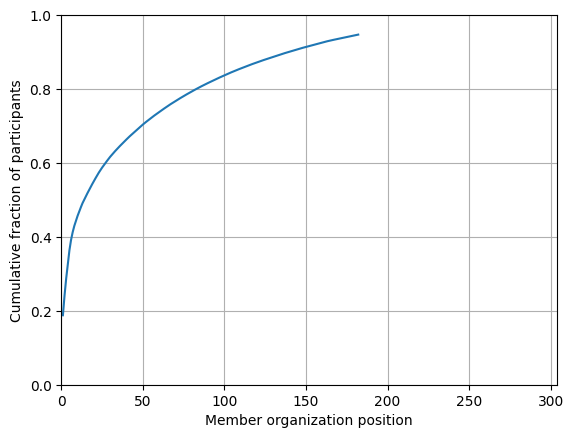

In [25]:
# Set minimum number of representatives an organization must have:
min_reps = 7

# Plot cummulative fraction of participants per organization position:
total_org_reps = members_df['org_name'].value_counts()
cum_org_reps = total_org_reps.cumsum()
most_cum_org_reps = cum_org_reps.loc[total_org_reps >= min_reps]
pl.plot(np.arange(1, 1 + len(most_cum_org_reps)), most_cum_org_reps.values / cum_org_reps.iloc[-1])
pl.xlim([0, len(total_org_reps)])
pl.ylim([0, 1])
pl.ylabel('Cumulative fraction of participants')
pl.xlabel('Member organization position')
pl.grid()
pl.show()

Count the number of participants in each group, from each organization:

In [12]:
# Count number of representatives from each organization (row), in each group (column):
large_members_df = members_df.loc[members_df['org_name'].isin(most_cum_org_reps.index)]
users_per_org_group_df = large_members_df.pivot_table(index='org_name',columns='group_name', values='user_name', aggfunc='count').fillna(0).astype(int)

# Print dataset shape:
n_orgs, n_groups = users_per_org_group_df.shape
print('# organizations:', n_orgs, '  # groups:', n_groups)

# organizations: 182   # groups: 191


#### Listing organizations with representatives

In [13]:
all_orgs_ids = set(all_orgs_df['org_id'].astype(int))
member_ids = set(members_df['org_id'].astype(int))
org_df.loc[org_df['org_id'].isin(member_ids)]

org_id                    org_name     org_discr is-member  \
20    142936                       GLEIF  organization      True   
22     54317       Newphoria Corporation  organization      True   
163    66234  National Library of Sweden  organization      True   
164    68998              Datagraph GmbH  organization      True   
165    69906           CANTON CONSULTING  organization      True   
...      ...                         ...           ...       ...   
3922   57941                 Viacom inc.  organization      True   
3963   99362          MEDIA DO Co., Ltd.  organization      True   
3964  110879               SHUEISHA Inc.  organization      True   
3969  133629             SHOGAKUKAN Inc.  organization      True   
4002   62643                   Bloomberg  organization      True   

     is-member-association                                    call  
20                   False  https://api.w3.org/affiliations/142936  
22                   False   https://api.w3.org/affiliations/54317  
163                  False   https://api.w3.org/affiliations/66234  
164                  False   https://api.w3.org/affiliations/68998  
165                  False   https://api.w3.org/affiliations/69906  
...                    ...                                     ...  
3922                 False   https://api.w3.org/affiliations/57941  
3963                 False   https://api.w3.org/affiliations/99362  
3964                 False  https://api.w3.org/affiliations/110879  
3969                 False  https://api.w3.org/affiliations/133629  
4002                 False   https://api.w3.org/affiliations/62643  

[304 rows x 6 columns]

### Model participation by interest in topics (LSA)

Let's perform a low-rank approximation to the participation matrix. This way, the groups will be described as topics and the organizations will be described accordingly to their interest in the topics.

In [14]:
# Create Latent Semantic Analysis Pipeline:
n_components = 8
tfidf = TfidfTransformer(norm='l1', use_idf=True, smooth_idf=True)
svd = TruncatedSVD(n_components=n_components, random_state=4872102)
lsa = Pipeline([('tfidf', tfidf), ('svd', svd)]) 

# Apply LSA to organizations:
org_vectors = lsa.fit_transform(users_per_org_group_df)
group_vectors = svd.components_.T

print('Explained variance:', svd.explained_variance_ratio_.sum().round(4))

Explained variance: 0.4153


In [15]:
# Estimate a signal-to-noise ratio:
# Number of data:
tot_participants = users_per_org_group_df.sum().sum()
# Number of parameters: 
model_deg_freedom = n_groups * n_components + n_orgs * n_components
# Average counts per bin (data per parameter):
data_per_bin = tot_participants / model_deg_freedom
# Expected signal over Poisson noise:
print('Avg. SNR:', (data_per_bin / np.sqrt(data_per_bin)).round(2))

Avg. SNR: 1.54


The number of components was chosen heuristically by visually inspecting the similarity matrix below.

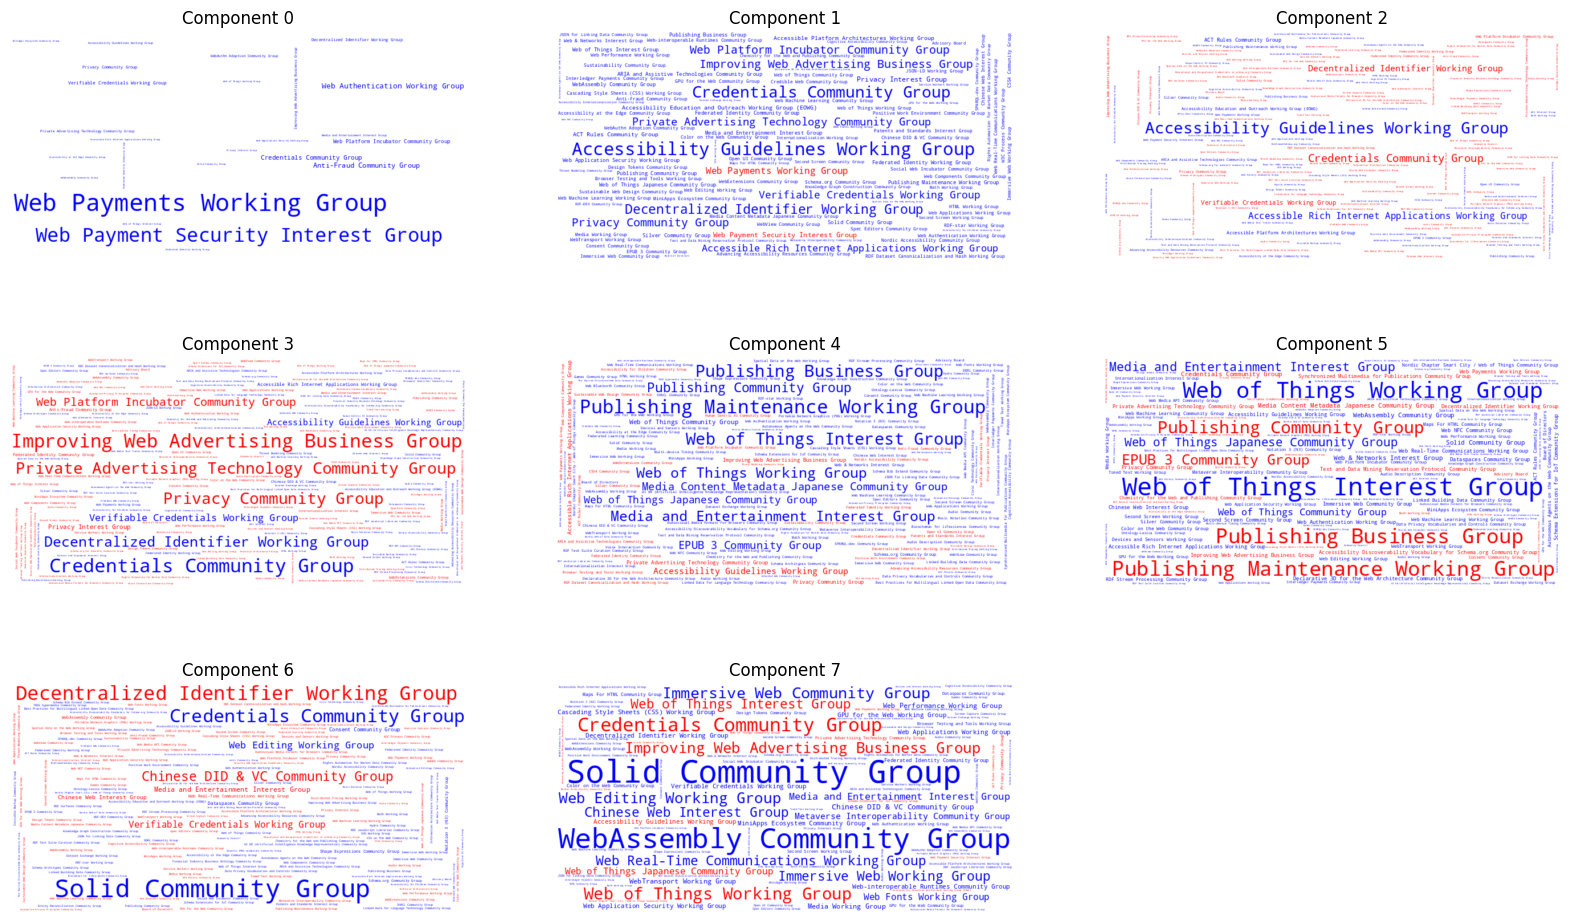

In [16]:
# Show the LSA components:
n_cols = 3
n_rows = int(n_components / n_cols) + 1
pl.figure(figsize=(20, 4 * n_rows))
for i in range(n_components):
    pl.subplot(n_rows, n_cols, i + 1)
    plot_word_vector(users_per_org_group_df.columns, svd.components_[i])
    pl.title('Component ' + str(i))

**Components interpretation**

From the components above, we identify the following broad topics: Payments, Accessibility, IDs & Credentials, Solid, Advertising, Publishing, Web of Things, WebAssembly.

There seems to be competing topics in the ID and Credentials: generic, solid and chinese.

In [17]:
# Manually name the topics of interest above:
component_names = {0:'Payments', 1:'General', 2:'Accessibility', 3:'IDs, not Advertising', 4:'Publishing', 5:'WoT, not Publishing', 6:'Solid, not DID', 7:'Solid + WebAssembly'}

### Compute simmilarity between organizations' interests

Compute the similarity matrix:

In [18]:
# Compute cosine sim. for organizations:
org_cossim_df = pd.DataFrame(data=cosine_similarity(org_vectors), index=users_per_org_group_df.index, columns=users_per_org_group_df.index)
org_cosdist_df = (1 - org_cossim_df).clip(lower=0)

In [19]:
# Compute cosine sim. for groups:
group_cossim_df = pd.DataFrame(data=cosine_similarity(group_vectors), index=users_per_org_group_df.columns, columns=users_per_org_group_df.columns)
group_cosdist_df = (1 - group_cossim_df).clip(lower=0)

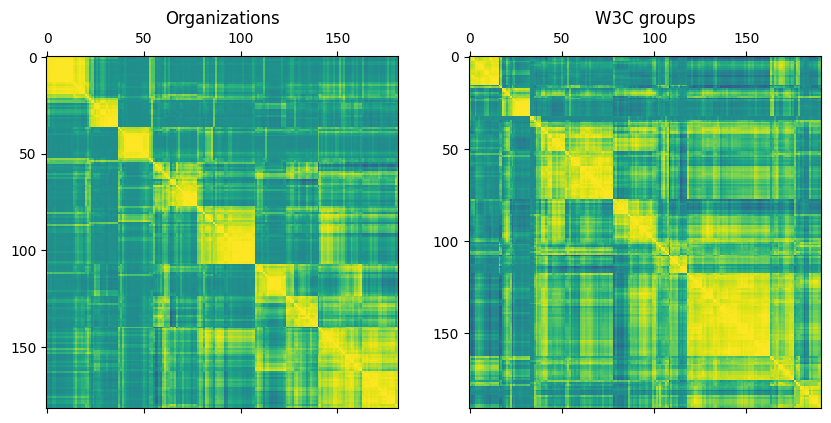

In [20]:
# Compute clustering linkage for organizations:
method = 'average'
linkage_matrix = linkage(squareform(org_cosdist_df.round(12)), method=method)
# Order org. names by similarity:
optimal_order = leaves_list(linkage_matrix)
sorted_org_cossim_df = org_cossim_df.iloc[optimal_order, optimal_order]
ordered_org_names = org_cossim_df.iloc[optimal_order].index

# Compute clustering linkage for W3C groups:
method = 'average'
group_linkage_matrix = linkage(squareform(group_cosdist_df.round(12)), method=method)
# Order org. names by similarity:
group_optimal_order = leaves_list(group_linkage_matrix)
sorted_group_cossim_df = group_cossim_df.iloc[group_optimal_order, group_optimal_order]
ordered_group_names = group_cossim_df.iloc[group_optimal_order].index

# Plot matrices:
fig, axes = pl.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].title.set_text('Organizations')
axes[0].matshow(sorted_org_cossim_df, vmin=-1, vmax=1)
axes[1].title.set_text('W3C groups')
axes[1].matshow(sorted_group_cossim_df, vmin=-1, vmax=1,)

pl.show()

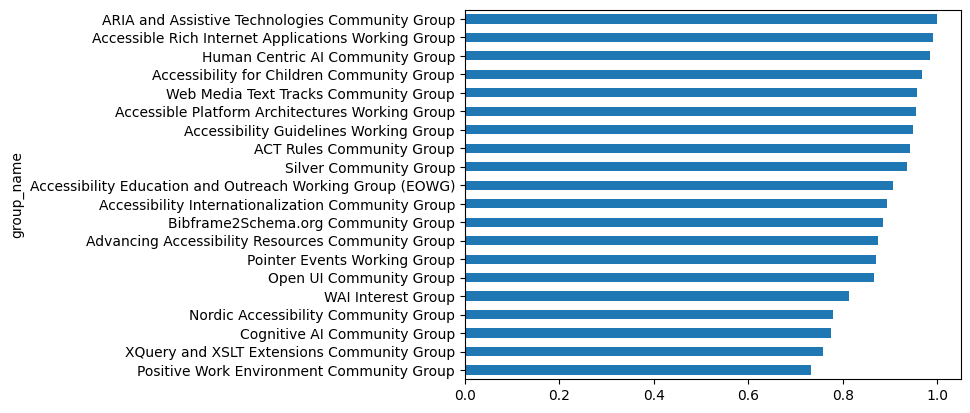

In [39]:
group_cossim_df.sample(axis=1).iloc[:,0].sort_values().tail(20).plot(kind='barh')
pl.show()

### Clustering the organizations

Let's guess a good number of clusters by finding the one that maximizes the distance gap between them:

In [21]:
# Extract the distances from the linkage matrix
distances = linkage_matrix[:, 2]
# Find the differences between successive distances
gaps = np.diff(distances)
# Identify the largest gap
max_gap_index = np.argmax(gaps)
# Get the number of clusters that maximizes the gap:
n_clusters_gap = len(gaps) - max_gap_index + 1
print('# clusters:', n_clusters_gap, 'Gap size:', gaps[max_gap_index], 'Gap gain:', gaps[max_gap_index] / gaps.mean())

# clusters: 7 Gap size: 0.1350300320065707 Gap gain: 27.28573812636796


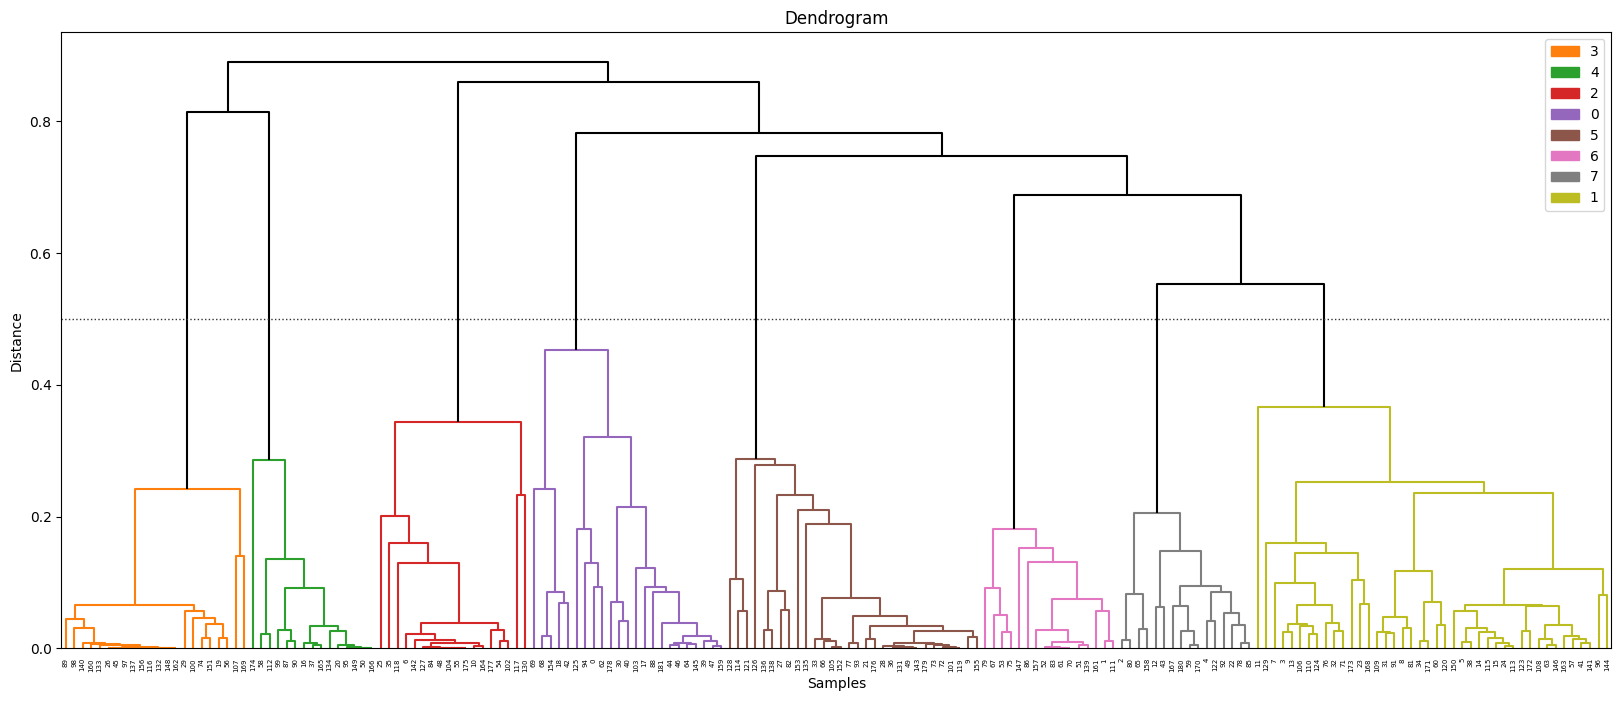

In [24]:
pl.figure(figsize=(20, 8))
dendout = dendrogram(linkage_matrix, above_threshold_color='k', color_threshold=0.5)
base_split = 0.5
pl.axhline(base_split, color='0.2', linewidth=1, linestyle='dotted')
pl.title('Dendrogram')
pl.xlabel('Samples')
pl.ylabel('Distance')

# Collect data from dendrogram:
org_cluster_dendout = org_cluster.iloc[dendout['leaves']]
org_dend_df = pd.DataFrame({'cluster_id': org_cluster_dendout, 'color': dendout['leaves_color_list']})
# Create legend:
org_cluster_dend_df = org_dend_df.drop_duplicates()
patches = [mpatches.Patch(color=org_cluster_dend_df['color'].iloc[i], label=str(org_cluster_dend_df['cluster_id'].iloc[i])) for i in range(n_clusters)]
pl.legend(handles=patches)

pl.show()

What we look for in the dendrogram above is a number of clusters that maximizes the distance between that cluster's previous merger and the next one. 
When this distance is large, the elements in the cluster are tightly packed while its distance to the nearest cluster (i.e., its next merger) is still large.

Now let's perform the clustering:

In [25]:
# Cluster organizations:
n_clusters = 8
aglo = AgglomerativeClustering(n_clusters=n_clusters, affinity='precomputed', linkage='average')
org_cluster = pd.Series(aglo.fit_predict(org_cosdist_df), index=org_cosdist_df.index, name='cluster_id')
cluster_orgs = {k: list(org_cluster.loc[org_cluster == k].index) for k in range(n_clusters)}

We can verify how the organizations in one cluster are similar among themselves or to those in different clusters:

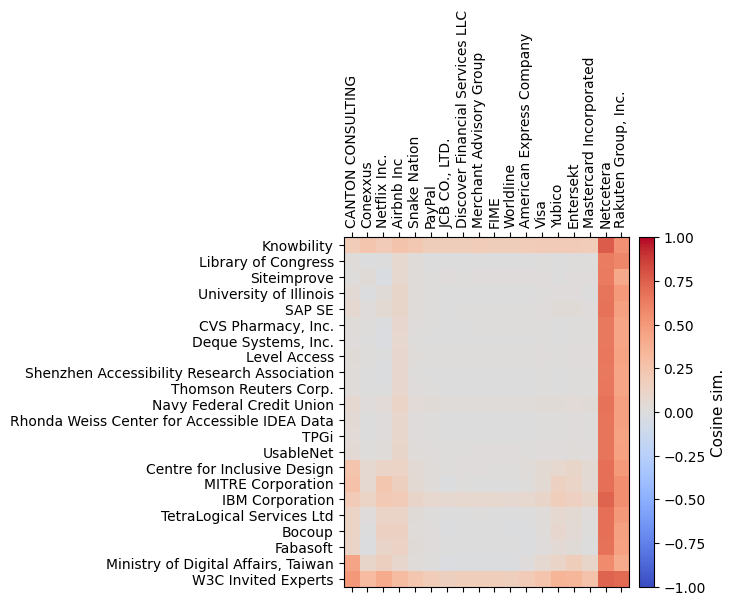

In [26]:
# Plot similarity matrix for two clusters:
x_orgs = ordered_org_names[ordered_org_names.isin(cluster_orgs[3])]
y_orgs = ordered_org_names[ordered_org_names.isin(cluster_orgs[2])]
xp.matrix_show(org_cossim_df.loc[x_orgs, y_orgs], 'coolwarm', 'Cosine sim.', vmin=-1, vmax=1)

### Understanding the reason organizations are similar

In [27]:
org_vectors_df = pd.DataFrame(data=org_vectors, index=users_per_org_group_df.index)
org_vectors_df.rename(component_names, axis=1, inplace=True)
org_vectors_df = org_vectors_df.loc[ordered_org_names]

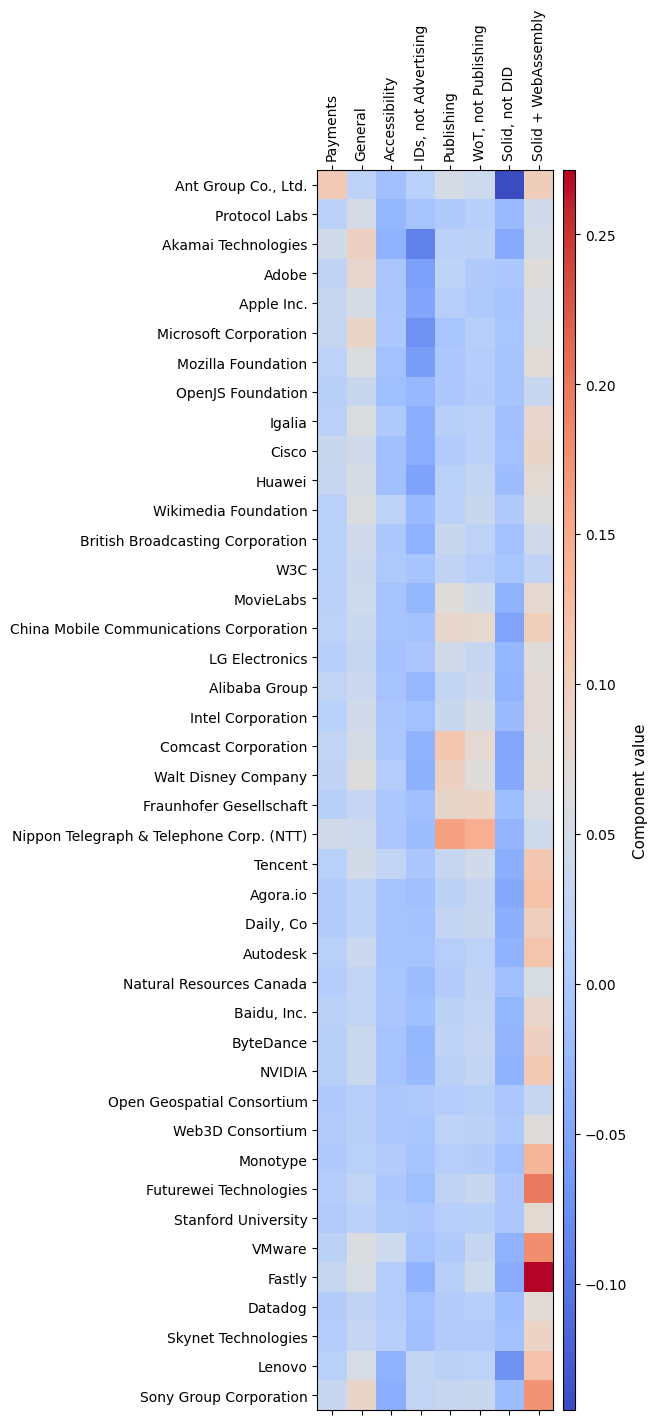

In [28]:
xp.matrix_show(org_vectors_df.loc[org_vectors_df.index.isin(cluster_orgs[1])], 'coolwarm', 'Component value')

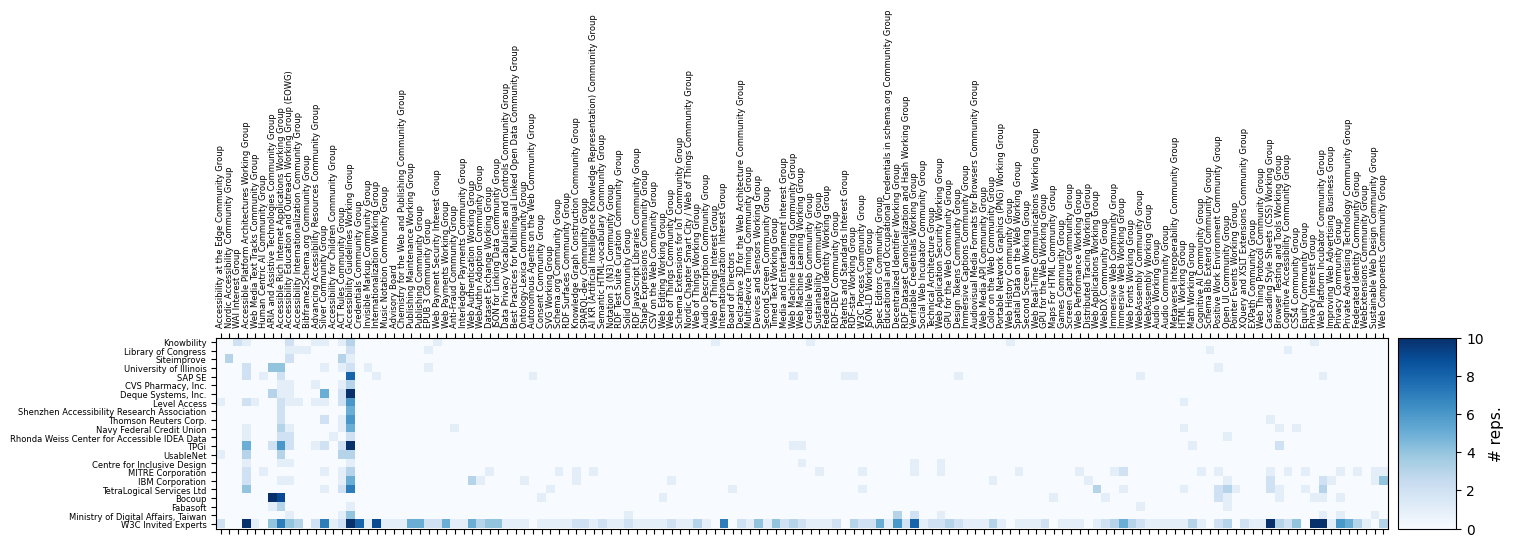

In [106]:
groups_by_cluster_df = users_per_org_group_df.loc[ordered_org_names, ordered_group_names]
groups_by_cluster_df = groups_by_cluster_df.loc[groups_by_cluster_df.index.isin(cluster_orgs[3])]
xp.matrix_show(groups_by_cluster_df.loc[:, groups_by_cluster_df.sum() > 0], 'Blues', '# reps.', vmax=10)
pl.tick_params(labelsize=6)

**Cluster interpretations**

* **1**: Hardware, media and telecom companies interested in WebAssembly, Hardware and Entertainment
* **7**: Universities and Government interested in Semantic Web and alike, strong Solid interest as well.
* **6**: Hardware companies interested in Web of Things and Entertainment.
* **5**: Web and News companies interested in surveillance (advertising, user identification and privacy).
* **0**: Companies and some Governments and Academia interested in DIDs and Credentials.
* **2**: Payment, security, transaction and retail companies interested in Payments, and authentication.
* **4**: Publishing companies interested in Publishing and consortium DAISY interested in accessible reading.
* **3**: W3C, Accessibility consulting companies, and others interested in Accessibility.

### Scatter plot of the organizations

In [80]:
# Project proximity on 2D plane:
tsne = TSNE(metric='precomputed', init='random', learning_rate='auto')
org_projxy = tsne.fit_transform(org_cosdist_df)
org_tsne_df = pd.DataFrame(data=org_projxy, index=users_per_org_group_df.index, columns=['tnse_x', 'tnse_y'])
org_tsne_df = org_tsne_df.join(org_cluster)

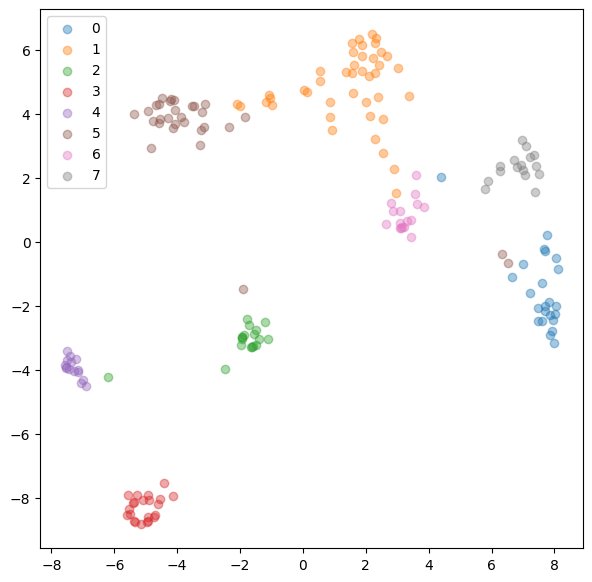

In [81]:
pl.figure(figsize=(7,7))
for i in range(n_clusters):
    sel_df = org_tsne_df.loc[org_tsne_df['cluster_id'] == i]
    pl.scatter(sel_df['tnse_x'], sel_df['tnse_y'], alpha=0.4, label=i)
pl.legend()
pl.show()

### 

## Main groups of interest

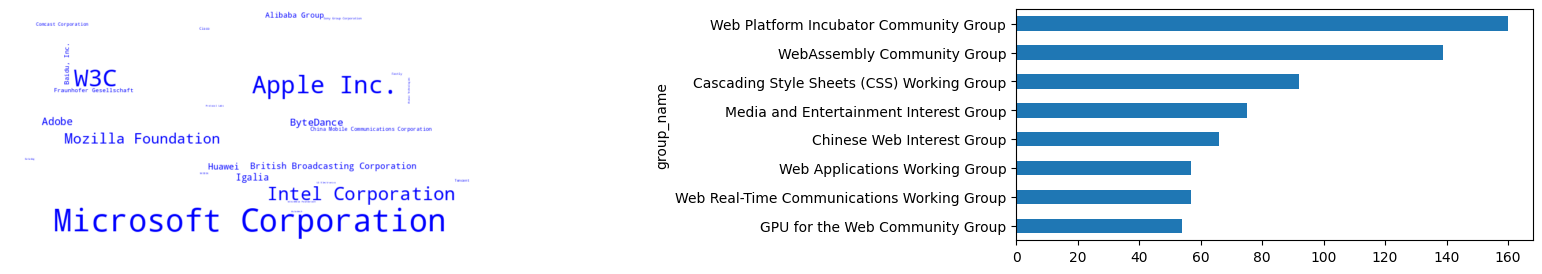

In [128]:
cid = 1

groups_by_cluster_df = users_per_org_group_df.loc[ordered_org_names, ordered_group_names]
groups_by_cluster_df = groups_by_cluster_df.loc[groups_by_cluster_df.index.isin(cluster_orgs[cid])]

pl.figure(figsize=(20, 3))

pl.subplot(1,2,1)
org_n_reps = groups_by_cluster_df.sum(axis=1)
org_n_reps = org_n_reps.loc[~org_n_reps.index.isin(['W3C Invited Experts', 'Google LLC'])]
xt.plot_word_vector(org_n_reps.index, org_n_reps.values)

pl.subplot(1,2,2)
org_n_reps = groups_by_cluster_df.sum(axis=1)
cluster_top_groups = groups_by_cluster_df.sum().sort_values()
cluster_top_groups = cluster_top_groups.loc[cluster_top_groups > 0]
cluster_top_groups.tail(8).plot(kind='barh')
pl.subplots_adjust(wspace=1)
pl.show()

# Tests

## LSA test

In [440]:
x = np.array([[0,30,10,0], [1,29,10,0], [30,0,0,10], [31,0,0,9], [15,0,0,5], [15,15,5,5]])
x

array([[ 0, 30, 10,  0],
       [ 1, 29, 10,  0],
       [30,  0,  0, 10],
       [31,  0,  0,  9],
       [15,  0,  0,  5],
       [15, 15,  5,  5]])

In [441]:
t = TfidfTransformer(norm='l2', use_idf=False, smooth_idf=True)
z = t.fit_transform(x).toarray()

In [442]:
m = TruncatedSVD(2)
u = m.fit_transform(x)
#u = m.fit_transform(z)
s = m.singular_values_
v = m.components_

In [443]:
pd.DataFrame(data=cosine_similarity(u))

0         1         2         3         4         5
0  1.000000  0.999517 -0.000037  0.000058 -0.000037  0.707134
1  0.999517  1.000000  0.031031  0.031125  0.031031  0.728760
2 -0.000037  0.031031  1.000000  1.000000  1.000000  0.707054
3  0.000058  0.031125  1.000000  1.000000  1.000000  0.707120
4 -0.000037  0.031031  1.000000  1.000000  1.000000  0.707054
5  0.707134  0.728760  0.707054  0.707120  0.707054  1.000000

In [444]:
pd.DataFrame(data=u.dot(u.T))

0           1            2            3           4           5
0  999.974210  970.042643    -0.036537     0.058754   -0.018268  499.968836
1  970.042643  941.916117    30.112341    30.826928   15.056171  500.077492
2   -0.036537   30.112341   999.746623  1020.378011  499.873312  499.855043
3    0.058754   30.826928  1020.378011  1041.435170  510.189005  510.218383
4   -0.018268   15.056171   499.873312   510.189005  249.936656  249.927522
5  499.968836  500.077492   499.855043   510.218383  249.927522  499.911940

In [445]:
pd.DataFrame(data=u.dot(u.T))

0           1            2            3           4           5
0  999.974210  970.042643    -0.036537     0.058754   -0.018268  499.968836
1  970.042643  941.916117    30.112341    30.826928   15.056171  500.077492
2   -0.036537   30.112341   999.746623  1020.378011  499.873312  499.855043
3    0.058754   30.826928  1020.378011  1041.435170  510.189005  510.218383
4   -0.018268   15.056171   499.873312   510.189005  249.936656  249.927522
5  499.968836  500.077492   499.855043   510.218383  249.927522  499.911940

In [446]:
pd.DataFrame(data=u.dot(v))

0          1          2         3
0   0.022909  29.954476  10.133992 -0.072382
1   0.931455  29.057981   9.830321  0.216868
2  30.151513   0.002634  -0.011557  9.520125
3  30.773740   0.005566  -0.010822  9.716581
4  15.075756   0.001317  -0.005779  4.760062
5  15.087211  14.978555   5.061218  4.723871

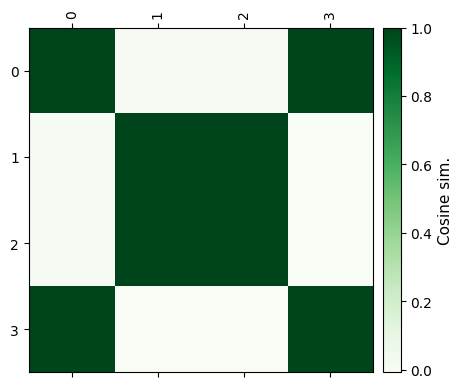

In [450]:
xp.matrix_show(pd.DataFrame(data=cosine_similarity(v.T)), 'Greens', 'Cosine sim.')